In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from keras import regularizers, optimizers, layers, models
from IPython.display import display
import os
%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET = 400
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 1000
BATCH_SIZE = 50
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 1024
REGULARIZATION_LAMBDA = 0.1

In [3]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

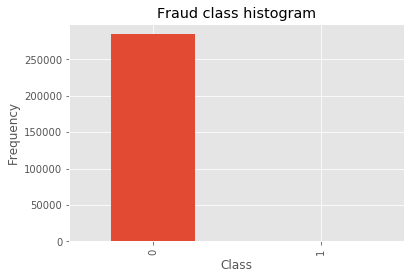

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [5]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = train_test_split(dataset, test_size = 0.2, random_state = 0)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [6]:
# Create balanced, under sample train and validation dataset 
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)

random_normal_indices = np.random.choice(normal_indices, NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET, replace = False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_dataset = dataset.iloc[under_sample_indices,:]

# Shuffle train and validation dataset
under_sample_dataset = under_sample_dataset.sample(frac=1)

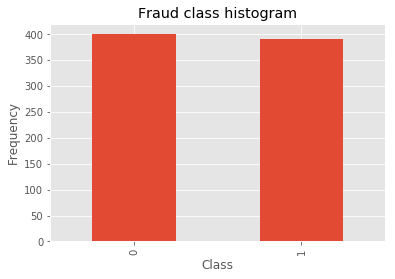

0    400
1    391
Name: Class, dtype: int64

In [7]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [8]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [9]:
# Pot loss
def show_loss(history):   
    x_axis = range(0, EPOCHS)
    fig, ax = plt.subplots()
    ax.plot(x_axis, history.history['loss'], label='train_loss')
    ax.plot(x_axis, history.history['val_loss'], label='val_loss')
    ax.legend()
    plt.ylabel('Log loss')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    
    plt.show()

In [28]:
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
# NN model
import keras.backend as K

def precision(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (TP_plus_FP + K.epsilon())

def recall(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (TP_plus_FN + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * prec * rec / (prec + rec + K.epsilon())

def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(NUMBER_OF_NEURONS,
                    input_dim=NUMBER_OF_FEATURES,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA)))
#     model.add(layers.Dense(NUMBER_OF_NEURONS, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimazier = optimizers.SGD(lr=LEARNING_RATE)
    model.compile(optimizer=optimazier,
                  loss='binary_crossentropy',
                  metrics=['accuracy', precision, recall, f1_score])
    return model

train_results = {'models': [], 'history': [], 'score': []}

kf = KFold(n_splits=N_SPLITS)
for train_index, validation_index in kf.split(under_sample_dataset):
    k_fold_train, k_fold_validation = under_sample_dataset[train_index], under_sample_dataset[validation_index]

    x_train = k_fold_train[:,:-1]
    y_train = k_fold_train[:,-1:]
        
    x_validation = k_fold_validation[:,:-1]
    y_validation = k_fold_validation[:,-1:]
    
    model = nn_model()
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(x_validation, y_validation, batch_size=BATCH_SIZE)
    
    train_results['models'].append(model)
    train_results['history'].append(history)
    train_results['score'].append(score)

Train on 632 samples, validate on 159 samples
Epoch 1/1000
632/632 [==============================] - 0s - loss: 6.0015 - acc: 0.6329 - precision: 0.5792 - recall: 0.9345 - f1_score: 0.7110 - val_loss: 5.9917 - val_acc: 0.5975 - val_precision: 0.5416 - val_recall: 0.9627 - val_f1_score: 0.6874
Epoch 2/1000
632/632 [==============================] - 0s - loss: 5.9384 - acc: 0.6329 - precision: 0.5811 - recall: 0.9528 - f1_score: 0.7198 - val_loss: 5.9449 - val_acc: 0.6101 - val_precision: 0.5504 - val_recall: 0.9627 - val_f1_score: 0.6942
Epoch 3/1000
632/632 [==============================] - 0s - loss: 5.8934 - acc: 0.6329 - precision: 0.5770 - recall: 0.9538 - f1_score: 0.7148 - val_loss: 5.9050 - val_acc: 0.6226 - val_precision: 0.5596 - val_recall: 0.9627 - val_f1_score: 0.7011
Epoch 4/1000
632/632 [==============================] - 0s - loss: 5.8540 - acc: 0.6392 - precision: 0.5827 - recall: 0.9537 - f1_score: 0.7198 - val_loss: 5.8681 - val_acc: 0.6289 - val_precision: 0.5642 - 

632/632 [==============================] - 0s - loss: 4.9936 - acc: 0.9161 - precision: 0.9194 - recall: 0.9137 - f1_score: 0.9152 - val_loss: 5.0068 - val_acc: 0.9119 - val_precision: 0.8773 - val_recall: 0.8815 - val_f1_score: 0.8760
Epoch 34/1000
632/632 [==============================] - 0s - loss: 4.9675 - acc: 0.9161 - precision: 0.9244 - recall: 0.9017 - f1_score: 0.9115 - val_loss: 4.9806 - val_acc: 0.9119 - val_precision: 0.8773 - val_recall: 0.8815 - val_f1_score: 0.8760
Epoch 35/1000
632/632 [==============================] - 0s - loss: 4.9416 - acc: 0.9161 - precision: 0.9316 - recall: 0.9031 - f1_score: 0.9154 - val_loss: 4.9546 - val_acc: 0.9119 - val_precision: 0.8773 - val_recall: 0.8815 - val_f1_score: 0.8760
Epoch 36/1000
632/632 [==============================] - 0s - loss: 4.9158 - acc: 0.9177 - precision: 0.9326 - recall: 0.9018 - f1_score: 0.9153 - val_loss: 4.9288 - val_acc: 0.9182 - val_precision: 0.8863 - val_recall: 0.8815 - val_f1_score: 0.8813
Epoch 37/1000


632/632 [==============================] - 0s - loss: 4.2373 - acc: 0.9335 - precision: 0.9734 - recall: 0.8923 - f1_score: 0.9293 - val_loss: 4.2492 - val_acc: 0.9371 - val_precision: 0.9303 - val_recall: 0.8442 - val_f1_score: 0.8848
Epoch 66/1000
632/632 [==============================] - 0s - loss: 4.2160 - acc: 0.9335 - precision: 0.9726 - recall: 0.8892 - f1_score: 0.9268 - val_loss: 4.2279 - val_acc: 0.9371 - val_precision: 0.9303 - val_recall: 0.8442 - val_f1_score: 0.8848
Epoch 67/1000
632/632 [==============================] - 0s - loss: 4.1948 - acc: 0.9335 - precision: 0.9720 - recall: 0.8920 - f1_score: 0.9293 - val_loss: 4.2067 - val_acc: 0.9371 - val_precision: 0.9303 - val_recall: 0.8442 - val_f1_score: 0.8848
Epoch 68/1000
632/632 [==============================] - 0s - loss: 4.1738 - acc: 0.9335 - precision: 0.9707 - recall: 0.8908 - f1_score: 0.9272 - val_loss: 4.1856 - val_acc: 0.9371 - val_precision: 0.9303 - val_recall: 0.8442 - val_f1_score: 0.8848
Epoch 69/1000


632/632 [==============================] - 0s - loss: 3.6125 - acc: 0.9320 - precision: 0.9730 - recall: 0.8887 - f1_score: 0.9277 - val_loss: 3.6248 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 98/1000
632/632 [==============================] - 0s - loss: 3.5947 - acc: 0.9320 - precision: 0.9732 - recall: 0.8875 - f1_score: 0.9274 - val_loss: 3.6070 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 99/1000
632/632 [==============================] - 0s - loss: 3.5771 - acc: 0.9320 - precision: 0.9738 - recall: 0.8885 - f1_score: 0.9261 - val_loss: 3.5894 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 100/1000
632/632 [==============================] - ETA: 0s - loss: 3.5492 - acc: 0.9600 - precision: 0.9130 - recall: 1.0000 - f1_score: 0.954 - 0s - loss: 3.5595 - acc: 0.9320 - precision: 0.9740 - recall: 0.8920 - f1_score: 0.9299 - val_loss: 3.5719 - val

632/632 [==============================] - 0s - loss: 3.1046 - acc: 0.9351 - precision: 0.9785 - recall: 0.8948 - f1_score: 0.9332 - val_loss: 3.1177 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 129/1000
632/632 [==============================] - 0s - loss: 3.0896 - acc: 0.9351 - precision: 0.9775 - recall: 0.8874 - f1_score: 0.9296 - val_loss: 3.1028 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 130/1000
632/632 [==============================] - 0s - loss: 3.0746 - acc: 0.9351 - precision: 0.9779 - recall: 0.8905 - f1_score: 0.9310 - val_loss: 3.0879 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 131/1000
632/632 [==============================] - 0s - loss: 3.0598 - acc: 0.9351 - precision: 0.9772 - recall: 0.8927 - f1_score: 0.9313 - val_loss: 3.0731 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 132/1

632/632 [==============================] - 0s - loss: 2.6622 - acc: 0.9320 - precision: 0.9759 - recall: 0.8770 - f1_score: 0.9231 - val_loss: 2.6764 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 161/1000
632/632 [==============================] - 0s - loss: 2.6495 - acc: 0.9320 - precision: 0.9791 - recall: 0.8849 - f1_score: 0.9280 - val_loss: 2.6638 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 162/1000
632/632 [==============================] - 0s - loss: 2.6369 - acc: 0.9320 - precision: 0.9796 - recall: 0.8836 - f1_score: 0.9284 - val_loss: 2.6512 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 163/1000
632/632 [==============================] - 0s - loss: 2.6244 - acc: 0.9320 - precision: 0.9757 - recall: 0.8844 - f1_score: 0.9265 - val_loss: 2.6388 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 164/1

632/632 [==============================] - 0s - loss: 2.2888 - acc: 0.9367 - precision: 0.9866 - recall: 0.8828 - f1_score: 0.9308 - val_loss: 2.3042 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 193/1000
632/632 [==============================] - 0s - loss: 2.2781 - acc: 0.9367 - precision: 0.9870 - recall: 0.8839 - f1_score: 0.9316 - val_loss: 2.2935 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 194/1000
632/632 [==============================] - 0s - loss: 2.2675 - acc: 0.9367 - precision: 0.9849 - recall: 0.8832 - f1_score: 0.9306 - val_loss: 2.2829 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 195/1000
632/632 [==============================] - 0s - loss: 2.2569 - acc: 0.9367 - precision: 0.9868 - recall: 0.8854 - f1_score: 0.9320 - val_loss: 2.2724 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 196/1

632/632 [==============================] - 0s - loss: 1.9733 - acc: 0.9383 - precision: 0.9899 - recall: 0.8862 - f1_score: 0.9332 - val_loss: 1.9898 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 225/1000
632/632 [==============================] - 0s - loss: 1.9642 - acc: 0.9383 - precision: 0.9886 - recall: 0.8874 - f1_score: 0.9339 - val_loss: 1.9808 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 226/1000
632/632 [==============================] - 0s - loss: 1.9553 - acc: 0.9383 - precision: 0.9898 - recall: 0.8883 - f1_score: 0.9340 - val_loss: 1.9718 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 227/1000
632/632 [==============================] - 0s - loss: 1.9463 - acc: 0.9383 - precision: 0.9886 - recall: 0.8819 - f1_score: 0.9308 - val_loss: 1.9629 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 228/1

632/632 [==============================] - 0s - loss: 1.7063 - acc: 0.9383 - precision: 0.9908 - recall: 0.8830 - f1_score: 0.9328 - val_loss: 1.7239 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 257/1000
632/632 [==============================] - 0s - loss: 1.6986 - acc: 0.9383 - precision: 0.9893 - recall: 0.8833 - f1_score: 0.9318 - val_loss: 1.7162 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 258/1000
632/632 [==============================] - 0s - loss: 1.6910 - acc: 0.9383 - precision: 0.9890 - recall: 0.8847 - f1_score: 0.9329 - val_loss: 1.7087 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 259/1000
632/632 [==============================] - 0s - loss: 1.6834 - acc: 0.9383 - precision: 0.9892 - recall: 0.8828 - f1_score: 0.9315 - val_loss: 1.7011 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 260/1

632/632 [==============================] - 0s - loss: 1.4801 - acc: 0.9383 - precision: 0.9882 - recall: 0.8810 - f1_score: 0.9299 - val_loss: 1.4988 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 289/1000
632/632 [==============================] - 0s - loss: 1.4736 - acc: 0.9383 - precision: 0.9885 - recall: 0.8834 - f1_score: 0.9318 - val_loss: 1.4924 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 290/1000
632/632 [==============================] - 0s - loss: 1.4672 - acc: 0.9383 - precision: 0.9905 - recall: 0.8871 - f1_score: 0.9348 - val_loss: 1.4859 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 291/1000
632/632 [==============================] - 0s - loss: 1.4608 - acc: 0.9383 - precision: 0.9895 - recall: 0.8840 - f1_score: 0.9327 - val_loss: 1.4796 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 292/1

632/632 [==============================] - 0s - loss: 1.2884 - acc: 0.9383 - precision: 0.9895 - recall: 0.8853 - f1_score: 0.9330 - val_loss: 1.3082 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 321/1000
632/632 [==============================] - 0s - loss: 1.2829 - acc: 0.9383 - precision: 0.9911 - recall: 0.8831 - f1_score: 0.9331 - val_loss: 1.3028 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 322/1000
632/632 [==============================] - 0s - loss: 1.2775 - acc: 0.9383 - precision: 0.9898 - recall: 0.8870 - f1_score: 0.9334 - val_loss: 1.2973 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 323/1000
632/632 [==============================] - 0s - loss: 1.2720 - acc: 0.9383 - precision: 0.9896 - recall: 0.8881 - f1_score: 0.9350 - val_loss: 1.2919 - val_acc: 0.9308 - val_precision: 0.9303 - val_recall: 0.8321 - val_f1_score: 0.8779
Epoch 324/1

632/632 [==============================] - 0s - loss: 1.1259 - acc: 0.9399 - precision: 0.9884 - recall: 0.8897 - f1_score: 0.9357 - val_loss: 1.1467 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 353/1000
632/632 [==============================] - 0s - loss: 1.1212 - acc: 0.9399 - precision: 0.9884 - recall: 0.8891 - f1_score: 0.9344 - val_loss: 1.1421 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 354/1000
632/632 [==============================] - 0s - loss: 1.1166 - acc: 0.9399 - precision: 0.9900 - recall: 0.8900 - f1_score: 0.9365 - val_loss: 1.1375 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 355/1000
632/632 [==============================] - 0s - loss: 1.1119 - acc: 0.9399 - precision: 0.9894 - recall: 0.8891 - f1_score: 0.9348 - val_loss: 1.1329 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 356/1

632/632 [==============================] - 0s - loss: 0.9879 - acc: 0.9399 - precision: 0.9882 - recall: 0.8885 - f1_score: 0.9351 - val_loss: 1.0097 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 385/1000
632/632 [==============================] - 0s - loss: 0.9839 - acc: 0.9399 - precision: 0.9892 - recall: 0.8947 - f1_score: 0.9385 - val_loss: 1.0058 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 386/1000
632/632 [==============================] - 0s - loss: 0.9800 - acc: 0.9399 - precision: 0.9906 - recall: 0.8895 - f1_score: 0.9368 - val_loss: 1.0019 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 387/1000
632/632 [==============================] - 0s - loss: 0.9760 - acc: 0.9399 - precision: 0.9907 - recall: 0.8921 - f1_score: 0.9371 - val_loss: 0.9980 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 388/1

632/632 [==============================] - 0s - loss: 0.8706 - acc: 0.9399 - precision: 0.9890 - recall: 0.8890 - f1_score: 0.9352 - val_loss: 0.8934 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 417/1000
632/632 [==============================] - 0s - loss: 0.8673 - acc: 0.9399 - precision: 0.9892 - recall: 0.8903 - f1_score: 0.9361 - val_loss: 0.8901 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 418/1000
632/632 [==============================] - 0s - loss: 0.8639 - acc: 0.9399 - precision: 0.9891 - recall: 0.8832 - f1_score: 0.9317 - val_loss: 0.8868 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 419/1000
632/632 [==============================] - 0s - loss: 0.8606 - acc: 0.9399 - precision: 0.9905 - recall: 0.8909 - f1_score: 0.9365 - val_loss: 0.8835 - val_acc: 0.9371 - val_precision: 0.9434 - val_recall: 0.8321 - val_f1_score: 0.8840
Epoch 420/1

632/632 [==============================] - 0s - loss: 0.7710 - acc: 0.9415 - precision: 0.9899 - recall: 0.8921 - f1_score: 0.9374 - val_loss: 0.7947 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 449/1000
632/632 [==============================] - 0s - loss: 0.7681 - acc: 0.9415 - precision: 0.9906 - recall: 0.8864 - f1_score: 0.9338 - val_loss: 0.7918 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 450/1000
632/632 [==============================] - 0s - loss: 0.7653 - acc: 0.9415 - precision: 0.9904 - recall: 0.8910 - f1_score: 0.9363 - val_loss: 0.7890 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 451/1000
632/632 [==============================] - 0s - loss: 0.7624 - acc: 0.9415 - precision: 0.9887 - recall: 0.8918 - f1_score: 0.9363 - val_loss: 0.7862 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 452/1

632/632 [==============================] - 0s - loss: 0.6862 - acc: 0.9415 - precision: 0.9888 - recall: 0.8884 - f1_score: 0.9351 - val_loss: 0.7108 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 481/1000
632/632 [==============================] - 0s - loss: 0.6838 - acc: 0.9415 - precision: 0.9887 - recall: 0.8904 - f1_score: 0.9360 - val_loss: 0.7084 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 482/1000
632/632 [==============================] - 0s - loss: 0.6813 - acc: 0.9415 - precision: 0.9895 - recall: 0.8919 - f1_score: 0.9374 - val_loss: 0.7060 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 483/1000
632/632 [==============================] - 0s - loss: 0.6789 - acc: 0.9415 - precision: 0.9899 - recall: 0.8937 - f1_score: 0.9381 - val_loss: 0.7036 - val_acc: 0.9434 - val_precision: 0.9434 - val_recall: 0.8447 - val_f1_score: 0.8907
Epoch 484/1

632/632 [==============================] - 0s - loss: 0.6140 - acc: 0.9430 - precision: 0.9890 - recall: 0.8942 - f1_score: 0.9385 - val_loss: 0.6394 - val_acc: 0.9497 - val_precision: 0.9434 - val_recall: 0.8573 - val_f1_score: 0.8977
Epoch 513/1000
632/632 [==============================] - 0s - loss: 0.6119 - acc: 0.9430 - precision: 0.9892 - recall: 0.8958 - f1_score: 0.9392 - val_loss: 0.6373 - val_acc: 0.9497 - val_precision: 0.9434 - val_recall: 0.8573 - val_f1_score: 0.8977
Epoch 514/1000
632/632 [==============================] - 0s - loss: 0.6099 - acc: 0.9430 - precision: 0.9906 - recall: 0.8963 - f1_score: 0.9391 - val_loss: 0.6353 - val_acc: 0.9497 - val_precision: 0.9434 - val_recall: 0.8573 - val_f1_score: 0.8977
Epoch 515/1000
632/632 [==============================] - 0s - loss: 0.6078 - acc: 0.9430 - precision: 0.9884 - recall: 0.8952 - f1_score: 0.9380 - val_loss: 0.6332 - val_acc: 0.9497 - val_precision: 0.9434 - val_recall: 0.8573 - val_f1_score: 0.8977
Epoch 516/1

632/632 [==============================] - 0s - loss: 0.5525 - acc: 0.9430 - precision: 0.9889 - recall: 0.8905 - f1_score: 0.9359 - val_loss: 0.5785 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 545/1000
632/632 [==============================] - 0s - loss: 0.5507 - acc: 0.9430 - precision: 0.9870 - recall: 0.8931 - f1_score: 0.9375 - val_loss: 0.5768 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 546/1000
632/632 [==============================] - 0s - loss: 0.5489 - acc: 0.9430 - precision: 0.9905 - recall: 0.8954 - f1_score: 0.9396 - val_loss: 0.5750 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 547/1000
632/632 [==============================] - 0s - loss: 0.5472 - acc: 0.9430 - precision: 0.9900 - recall: 0.8923 - f1_score: 0.9369 - val_loss: 0.5733 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 548/1

632/632 [==============================] - 0s - loss: 0.4999 - acc: 0.9430 - precision: 0.9890 - recall: 0.8932 - f1_score: 0.9374 - val_loss: 0.5267 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 577/1000
632/632 [==============================] - 0s - loss: 0.4984 - acc: 0.9430 - precision: 0.9904 - recall: 0.8960 - f1_score: 0.9397 - val_loss: 0.5252 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 578/1000
632/632 [==============================] - 0s - loss: 0.4969 - acc: 0.9430 - precision: 0.9888 - recall: 0.8918 - f1_score: 0.9369 - val_loss: 0.5237 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 579/1000
632/632 [==============================] - 0s - loss: 0.4954 - acc: 0.9430 - precision: 0.9902 - recall: 0.8994 - f1_score: 0.9418 - val_loss: 0.5223 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 580/1

632/632 [==============================] - 0s - loss: 0.4550 - acc: 0.9430 - precision: 0.9917 - recall: 0.8920 - f1_score: 0.9380 - val_loss: 0.4824 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 609/1000
632/632 [==============================] - 0s - loss: 0.4537 - acc: 0.9430 - precision: 0.9901 - recall: 0.8948 - f1_score: 0.9391 - val_loss: 0.4812 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 610/1000
632/632 [==============================] - 0s - loss: 0.4524 - acc: 0.9430 - precision: 0.9896 - recall: 0.8937 - f1_score: 0.9383 - val_loss: 0.4799 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 611/1000
632/632 [==============================] - 0s - loss: 0.4511 - acc: 0.9430 - precision: 0.9894 - recall: 0.8959 - f1_score: 0.9392 - val_loss: 0.4786 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 612/1

632/632 [==============================] - 0s - loss: 0.4166 - acc: 0.9446 - precision: 0.9907 - recall: 0.8962 - f1_score: 0.9400 - val_loss: 0.4446 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 641/1000
632/632 [==============================] - 0s - loss: 0.4155 - acc: 0.9446 - precision: 0.9907 - recall: 0.8979 - f1_score: 0.9412 - val_loss: 0.4435 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 642/1000
632/632 [==============================] - 0s - loss: 0.4144 - acc: 0.9446 - precision: 0.9897 - recall: 0.8983 - f1_score: 0.9396 - val_loss: 0.4424 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 643/1000
632/632 [==============================] - 0s - loss: 0.4133 - acc: 0.9446 - precision: 0.9882 - recall: 0.9006 - f1_score: 0.9411 - val_loss: 0.4413 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 644/1

632/632 [==============================] - 0s - loss: 0.3836 - acc: 0.9446 - precision: 0.9911 - recall: 0.8979 - f1_score: 0.9410 - val_loss: 0.4122 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 673/1000
632/632 [==============================] - 0s - loss: 0.3827 - acc: 0.9446 - precision: 0.9886 - recall: 0.8862 - f1_score: 0.9323 - val_loss: 0.4113 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 674/1000
632/632 [==============================] - 0s - loss: 0.3818 - acc: 0.9446 - precision: 0.9895 - recall: 0.9017 - f1_score: 0.9422 - val_loss: 0.4103 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 675/1000
632/632 [==============================] - 0s - loss: 0.3808 - acc: 0.9446 - precision: 0.9886 - recall: 0.9055 - f1_score: 0.9433 - val_loss: 0.4094 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 676/1

632/632 [==============================] - 0s - loss: 0.3554 - acc: 0.9446 - precision: 0.9904 - recall: 0.9080 - f1_score: 0.9455 - val_loss: 0.3845 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 705/1000
632/632 [==============================] - 0s - loss: 0.3546 - acc: 0.9446 - precision: 0.9898 - recall: 0.8974 - f1_score: 0.9410 - val_loss: 0.3837 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 706/1000
632/632 [==============================] - 0s - loss: 0.3537 - acc: 0.9446 - precision: 0.9904 - recall: 0.8994 - f1_score: 0.9414 - val_loss: 0.3829 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 707/1000
632/632 [==============================] - 0s - loss: 0.3529 - acc: 0.9446 - precision: 0.9879 - recall: 0.8992 - f1_score: 0.9405 - val_loss: 0.3821 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 708/1

632/632 [==============================] - 0s - loss: 0.3311 - acc: 0.9446 - precision: 0.9882 - recall: 0.9008 - f1_score: 0.9416 - val_loss: 0.3607 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 737/1000
632/632 [==============================] - 0s - loss: 0.3304 - acc: 0.9446 - precision: 0.9895 - recall: 0.8996 - f1_score: 0.9414 - val_loss: 0.3600 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 738/1000
632/632 [==============================] - 0s - loss: 0.3297 - acc: 0.9446 - precision: 0.9899 - recall: 0.9009 - f1_score: 0.9425 - val_loss: 0.3593 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 739/1000
632/632 [==============================] - 0s - loss: 0.3290 - acc: 0.9446 - precision: 0.9896 - recall: 0.8983 - f1_score: 0.9405 - val_loss: 0.3586 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 740/1

632/632 [==============================] - 0s - loss: 0.3102 - acc: 0.9446 - precision: 0.9881 - recall: 0.8952 - f1_score: 0.9387 - val_loss: 0.3402 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 769/1000
632/632 [==============================] - 0s - loss: 0.3096 - acc: 0.9446 - precision: 0.9896 - recall: 0.8973 - f1_score: 0.9402 - val_loss: 0.3396 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 770/1000
632/632 [==============================] - 0s - loss: 0.3090 - acc: 0.9446 - precision: 0.9909 - recall: 0.8994 - f1_score: 0.9420 - val_loss: 0.3391 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 771/1000
632/632 [==============================] - 0s - loss: 0.3084 - acc: 0.9446 - precision: 0.9880 - recall: 0.8948 - f1_score: 0.9387 - val_loss: 0.3385 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 772/1

632/632 [==============================] - 0s - loss: 0.2927 - acc: 0.9446 - precision: 0.9901 - recall: 0.8989 - f1_score: 0.9406 - val_loss: 0.3231 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 800/1000
632/632 [==============================] - 0s - loss: 0.2922 - acc: 0.9446 - precision: 0.9900 - recall: 0.8995 - f1_score: 0.9412 - val_loss: 0.3226 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 801/1000
632/632 [==============================] - 0s - loss: 0.2917 - acc: 0.9446 - precision: 0.9886 - recall: 0.8969 - f1_score: 0.9395 - val_loss: 0.3221 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 802/1000
632/632 [==============================] - 0s - loss: 0.2912 - acc: 0.9446 - precision: 0.9899 - recall: 0.8996 - f1_score: 0.9419 - val_loss: 0.3216 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 803/1

632/632 [==============================] - 0s - loss: 0.2771 - acc: 0.9446 - precision: 0.9894 - recall: 0.8968 - f1_score: 0.9399 - val_loss: 0.3077 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 832/1000
632/632 [==============================] - 0s - loss: 0.2766 - acc: 0.9446 - precision: 0.9891 - recall: 0.9013 - f1_score: 0.9425 - val_loss: 0.3073 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 833/1000
632/632 [==============================] - 0s - loss: 0.2762 - acc: 0.9446 - precision: 0.9878 - recall: 0.8950 - f1_score: 0.9381 - val_loss: 0.3068 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 834/1000
632/632 [==============================] - 0s - loss: 0.2757 - acc: 0.9446 - precision: 0.9884 - recall: 0.8967 - f1_score: 0.9394 - val_loss: 0.3064 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 835/1

632/632 [==============================] - 0s - loss: 0.2636 - acc: 0.9446 - precision: 0.9901 - recall: 0.8995 - f1_score: 0.9409 - val_loss: 0.2945 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 864/1000
632/632 [==============================] - 0s - loss: 0.2632 - acc: 0.9446 - precision: 0.9876 - recall: 0.8927 - f1_score: 0.9368 - val_loss: 0.2941 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 865/1000
632/632 [==============================] - 0s - loss: 0.2628 - acc: 0.9446 - precision: 0.9896 - recall: 0.9001 - f1_score: 0.9416 - val_loss: 0.2937 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 866/1000
632/632 [==============================] - 0s - loss: 0.2624 - acc: 0.9446 - precision: 0.9895 - recall: 0.9014 - f1_score: 0.9420 - val_loss: 0.2933 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 867/1

632/632 [==============================] - 0s - loss: 0.2519 - acc: 0.9446 - precision: 0.9903 - recall: 0.8965 - f1_score: 0.9402 - val_loss: 0.2830 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 896/1000
632/632 [==============================] - 0s - loss: 0.2516 - acc: 0.9446 - precision: 0.9893 - recall: 0.8940 - f1_score: 0.9380 - val_loss: 0.2826 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 897/1000
632/632 [==============================] - 0s - loss: 0.2512 - acc: 0.9446 - precision: 0.9895 - recall: 0.8988 - f1_score: 0.9415 - val_loss: 0.2823 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 898/1000
632/632 [==============================] - 0s - loss: 0.2509 - acc: 0.9446 - precision: 0.9891 - recall: 0.9001 - f1_score: 0.9412 - val_loss: 0.2820 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 899/1

632/632 [==============================] - 0s - loss: 0.2417 - acc: 0.9446 - precision: 0.9889 - recall: 0.8960 - f1_score: 0.9391 - val_loss: 0.2730 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 928/1000
632/632 [==============================] - 0s - loss: 0.2415 - acc: 0.9446 - precision: 0.9906 - recall: 0.9013 - f1_score: 0.9420 - val_loss: 0.2727 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 929/1000
632/632 [==============================] - 0s - loss: 0.2412 - acc: 0.9446 - precision: 0.9875 - recall: 0.8963 - f1_score: 0.9386 - val_loss: 0.2724 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 930/1000
632/632 [==============================] - 0s - loss: 0.2409 - acc: 0.9446 - precision: 0.9897 - recall: 0.8911 - f1_score: 0.9363 - val_loss: 0.2721 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 931/1

632/632 [==============================] - 0s - loss: 0.2330 - acc: 0.9446 - precision: 0.9895 - recall: 0.8968 - f1_score: 0.9403 - val_loss: 0.2643 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 960/1000
632/632 [==============================] - 0s - loss: 0.2327 - acc: 0.9446 - precision: 0.9883 - recall: 0.8980 - f1_score: 0.9389 - val_loss: 0.2641 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 961/1000
632/632 [==============================] - 0s - loss: 0.2325 - acc: 0.9446 - precision: 0.9907 - recall: 0.8972 - f1_score: 0.9405 - val_loss: 0.2638 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 962/1000
632/632 [==============================] - 0s - loss: 0.2322 - acc: 0.9446 - precision: 0.9904 - recall: 0.8952 - f1_score: 0.9393 - val_loss: 0.2636 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 963/1

632/632 [==============================] - 0s - loss: 0.2253 - acc: 0.9446 - precision: 0.9899 - recall: 0.8968 - f1_score: 0.9401 - val_loss: 0.2568 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 992/1000
632/632 [==============================] - 0s - loss: 0.2251 - acc: 0.9446 - precision: 0.9894 - recall: 0.8959 - f1_score: 0.9388 - val_loss: 0.2566 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 993/1000
632/632 [==============================] - 0s - loss: 0.2249 - acc: 0.9446 - precision: 0.9909 - recall: 0.8956 - f1_score: 0.9392 - val_loss: 0.2564 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 994/1000
632/632 [==============================] - 0s - loss: 0.2247 - acc: 0.9446 - precision: 0.9888 - recall: 0.8969 - f1_score: 0.9392 - val_loss: 0.2561 - val_acc: 0.9434 - val_precision: 0.9303 - val_recall: 0.8573 - val_f1_score: 0.8915
Epoch 995/1

633/633 [==============================] - 0s - loss: 5.2362 - acc: 0.9131 - precision: 0.8901 - recall: 0.9434 - f1_score: 0.9141 - val_loss: 5.2263 - val_acc: 0.9051 - val_precision: 0.9131 - val_recall: 0.9065 - val_f1_score: 0.9089
Epoch 24/1000
633/633 [==============================] - 0s - loss: 5.2079 - acc: 0.9226 - precision: 0.8986 - recall: 0.9342 - f1_score: 0.9146 - val_loss: 5.1991 - val_acc: 0.9051 - val_precision: 0.9131 - val_recall: 0.9065 - val_f1_score: 0.9089
Epoch 25/1000
633/633 [==============================] - 0s - loss: 5.1798 - acc: 0.9258 - precision: 0.9111 - recall: 0.9357 - f1_score: 0.9216 - val_loss: 5.1722 - val_acc: 0.8987 - val_precision: 0.9124 - val_recall: 0.8969 - val_f1_score: 0.9034
Epoch 26/1000
633/633 [==============================] - 0s - loss: 5.1519 - acc: 0.9289 - precision: 0.9173 - recall: 0.9372 - f1_score: 0.9255 - val_loss: 5.1454 - val_acc: 0.9051 - val_precision: 0.9239 - val_recall: 0.8969 - val_f1_score: 0.9095
Epoch 27/1000


633/633 [==============================] - 0s - loss: 4.4262 - acc: 0.9479 - precision: 0.9790 - recall: 0.9139 - f1_score: 0.9447 - val_loss: 4.4429 - val_acc: 0.9051 - val_precision: 0.9691 - val_recall: 0.8466 - val_f1_score: 0.9031
Epoch 56/1000
633/633 [==============================] - 0s - loss: 4.4036 - acc: 0.9479 - precision: 0.9802 - recall: 0.9127 - f1_score: 0.9443 - val_loss: 4.4208 - val_acc: 0.9051 - val_precision: 0.9691 - val_recall: 0.8466 - val_f1_score: 0.9031
Epoch 57/1000
633/633 [==============================] - 0s - loss: 4.3811 - acc: 0.9479 - precision: 0.9778 - recall: 0.9113 - f1_score: 0.9425 - val_loss: 4.3989 - val_acc: 0.9051 - val_precision: 0.9691 - val_recall: 0.8466 - val_f1_score: 0.9031
Epoch 58/1000
633/633 [==============================] - 0s - loss: 4.3588 - acc: 0.9479 - precision: 0.9771 - recall: 0.9077 - f1_score: 0.9401 - val_loss: 4.3772 - val_acc: 0.9051 - val_precision: 0.9691 - val_recall: 0.8466 - val_f1_score: 0.9031
Epoch 59/1000


633/633 [==============================] - 0s - loss: 3.7663 - acc: 0.9447 - precision: 0.9783 - recall: 0.9036 - f1_score: 0.9383 - val_loss: 3.7972 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 88/1000
633/633 [==============================] - 0s - loss: 3.7476 - acc: 0.9431 - precision: 0.9774 - recall: 0.8974 - f1_score: 0.9347 - val_loss: 3.7788 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 89/1000
633/633 [==============================] - 0s - loss: 3.7290 - acc: 0.9431 - precision: 0.9810 - recall: 0.8996 - f1_score: 0.9375 - val_loss: 3.7605 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 90/1000
633/633 [==============================] - 0s - loss: 3.7105 - acc: 0.9431 - precision: 0.9799 - recall: 0.9042 - f1_score: 0.9392 - val_loss: 3.7424 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 91/1000


633/633 [==============================] - 0s - loss: 3.2168 - acc: 0.9431 - precision: 0.9785 - recall: 0.9019 - f1_score: 0.9377 - val_loss: 3.2564 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 120/1000
633/633 [==============================] - 0s - loss: 3.2011 - acc: 0.9431 - precision: 0.9799 - recall: 0.9022 - f1_score: 0.9377 - val_loss: 3.2409 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 121/1000
633/633 [==============================] - 0s - loss: 3.1855 - acc: 0.9431 - precision: 0.9774 - recall: 0.9002 - f1_score: 0.9362 - val_loss: 3.2255 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 122/1000
633/633 [==============================] - 0s - loss: 3.1700 - acc: 0.9431 - precision: 0.9790 - recall: 0.9001 - f1_score: 0.9368 - val_loss: 3.2102 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8082 - val_f1_score: 0.8867
Epoch 123/1

633/633 [==============================] - 0s - loss: 2.7685 - acc: 0.9415 - precision: 0.9796 - recall: 0.9026 - f1_score: 0.9389 - val_loss: 2.8136 - val_acc: 0.8861 - val_precision: 0.9849 - val_recall: 0.7986 - val_f1_score: 0.8806
Epoch 151/1000
633/633 [==============================] - 0s - loss: 2.7553 - acc: 0.9415 - precision: 0.9794 - recall: 0.9027 - f1_score: 0.9385 - val_loss: 2.8005 - val_acc: 0.8861 - val_precision: 0.9849 - val_recall: 0.7986 - val_f1_score: 0.8806
Epoch 152/1000
633/633 [==============================] - 0s - loss: 2.7421 - acc: 0.9415 - precision: 0.9781 - recall: 0.9004 - f1_score: 0.9356 - val_loss: 2.7874 - val_acc: 0.8861 - val_precision: 0.9849 - val_recall: 0.7986 - val_f1_score: 0.8806
Epoch 153/1000
633/633 [==============================] - 0s - loss: 2.7290 - acc: 0.9415 - precision: 0.9773 - recall: 0.8998 - f1_score: 0.9363 - val_loss: 2.7745 - val_acc: 0.8861 - val_precision: 0.9849 - val_recall: 0.7986 - val_f1_score: 0.8806
Epoch 154/1

633/633 [==============================] - 0s - loss: 2.3774 - acc: 0.9415 - precision: 0.9788 - recall: 0.8994 - f1_score: 0.9356 - val_loss: 2.4263 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 183/1000
633/633 [==============================] - 0s - loss: 2.3662 - acc: 0.9415 - precision: 0.9807 - recall: 0.8982 - f1_score: 0.9349 - val_loss: 2.4153 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 184/1000
633/633 [==============================] - 0s - loss: 2.3551 - acc: 0.9415 - precision: 0.9798 - recall: 0.8987 - f1_score: 0.9363 - val_loss: 2.4042 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 185/1000
633/633 [==============================] - 0s - loss: 2.3440 - acc: 0.9415 - precision: 0.9789 - recall: 0.9057 - f1_score: 0.9394 - val_loss: 2.3933 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 186/1

633/633 [==============================] - 0s - loss: 2.0470 - acc: 0.9415 - precision: 0.9801 - recall: 0.8992 - f1_score: 0.9363 - val_loss: 2.0987 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 215/1000
633/633 [==============================] - 0s - loss: 2.0375 - acc: 0.9415 - precision: 0.9787 - recall: 0.8979 - f1_score: 0.9356 - val_loss: 2.0893 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 216/1000
633/633 [==============================] - 0s - loss: 2.0281 - acc: 0.9415 - precision: 0.9792 - recall: 0.8990 - f1_score: 0.9362 - val_loss: 2.0800 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 217/1000
633/633 [==============================] - 0s - loss: 2.0188 - acc: 0.9415 - precision: 0.9790 - recall: 0.9013 - f1_score: 0.9378 - val_loss: 2.0707 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 218/1

633/633 [==============================] - 0s - loss: 1.7676 - acc: 0.9431 - precision: 0.9796 - recall: 0.9028 - f1_score: 0.9386 - val_loss: 1.8213 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 247/1000
633/633 [==============================] - 0s - loss: 1.7595 - acc: 0.9431 - precision: 0.9783 - recall: 0.9021 - f1_score: 0.9374 - val_loss: 1.8134 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 248/1000
633/633 [==============================] - 0s - loss: 1.7516 - acc: 0.9431 - precision: 0.9798 - recall: 0.9081 - f1_score: 0.9413 - val_loss: 1.8055 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 249/1000
633/633 [==============================] - 0s - loss: 1.7437 - acc: 0.9431 - precision: 0.9783 - recall: 0.9042 - f1_score: 0.9390 - val_loss: 1.7976 - val_acc: 0.8924 - val_precision: 0.9849 - val_recall: 0.8130 - val_f1_score: 0.8895
Epoch 250/1

633/633 [==============================] - 0s - loss: 1.5309 - acc: 0.9415 - precision: 0.9776 - recall: 0.8995 - f1_score: 0.9360 - val_loss: 1.5862 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 279/1000
633/633 [==============================] - 0s - loss: 1.5241 - acc: 0.9415 - precision: 0.9778 - recall: 0.8986 - f1_score: 0.9353 - val_loss: 1.5795 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 280/1000
633/633 [==============================] - 0s - loss: 1.5174 - acc: 0.9415 - precision: 0.9780 - recall: 0.9013 - f1_score: 0.9370 - val_loss: 1.5728 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 281/1000
633/633 [==============================] - 0s - loss: 1.5107 - acc: 0.9415 - precision: 0.9783 - recall: 0.8981 - f1_score: 0.9359 - val_loss: 1.5661 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 282/1

633/633 [==============================] - 0s - loss: 1.3304 - acc: 0.9431 - precision: 0.9785 - recall: 0.8992 - f1_score: 0.9351 - val_loss: 1.3868 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 311/1000
633/633 [==============================] - 0s - loss: 1.3246 - acc: 0.9431 - precision: 0.9775 - recall: 0.9065 - f1_score: 0.9396 - val_loss: 1.3811 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 312/1000
633/633 [==============================] - 0s - loss: 1.3189 - acc: 0.9431 - precision: 0.9790 - recall: 0.9018 - f1_score: 0.9376 - val_loss: 1.3754 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 313/1000
633/633 [==============================] - 0s - loss: 1.3132 - acc: 0.9431 - precision: 0.9789 - recall: 0.9070 - f1_score: 0.9409 - val_loss: 1.3698 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 314/1

633/633 [==============================] - 0s - loss: 1.1603 - acc: 0.9431 - precision: 0.9782 - recall: 0.9022 - f1_score: 0.9378 - val_loss: 1.2177 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 343/1000
633/633 [==============================] - 0s - loss: 1.1554 - acc: 0.9431 - precision: 0.9776 - recall: 0.9065 - f1_score: 0.9393 - val_loss: 1.2129 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 344/1000
633/633 [==============================] - 0s - loss: 1.1506 - acc: 0.9431 - precision: 0.9788 - recall: 0.9054 - f1_score: 0.9400 - val_loss: 1.2081 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 345/1000
633/633 [==============================] - 0s - loss: 1.1457 - acc: 0.9431 - precision: 0.9791 - recall: 0.9041 - f1_score: 0.9394 - val_loss: 1.2033 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 346/1

633/633 [==============================] - 0s - loss: 1.0160 - acc: 0.9431 - precision: 0.9767 - recall: 0.9035 - f1_score: 0.9382 - val_loss: 1.0742 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 375/1000
633/633 [==============================] - 0s - loss: 1.0118 - acc: 0.9447 - precision: 0.9840 - recall: 0.9003 - f1_score: 0.9388 - val_loss: 1.0701 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 376/1000
633/633 [==============================] - 0s - loss: 1.0077 - acc: 0.9431 - precision: 0.9769 - recall: 0.8986 - f1_score: 0.9352 - val_loss: 1.0660 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 377/1000
633/633 [==============================] - 0s - loss: 1.0036 - acc: 0.9447 - precision: 0.9821 - recall: 0.9022 - f1_score: 0.9395 - val_loss: 1.0620 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 378/1

633/633 [==============================] - 0s - loss: 0.8934 - acc: 0.9447 - precision: 0.9823 - recall: 0.9072 - f1_score: 0.9424 - val_loss: 0.9524 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 407/1000
633/633 [==============================] - 0s - loss: 0.8899 - acc: 0.9447 - precision: 0.9845 - recall: 0.9019 - f1_score: 0.9399 - val_loss: 0.9489 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 408/1000
633/633 [==============================] - 0s - loss: 0.8864 - acc: 0.9447 - precision: 0.9838 - recall: 0.9014 - f1_score: 0.9392 - val_loss: 0.9454 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 409/1000
633/633 [==============================] - 0s - loss: 0.8829 - acc: 0.9447 - precision: 0.9834 - recall: 0.9077 - f1_score: 0.9431 - val_loss: 0.9419 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 410/1

633/633 [==============================] - 0s - loss: 0.7892 - acc: 0.9447 - precision: 0.9803 - recall: 0.9029 - f1_score: 0.9385 - val_loss: 0.8488 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 439/1000
633/633 [==============================] - ETA: 0s - loss: 0.7824 - acc: 0.9460 - precision: 0.9832 - recall: 0.9123 - f1_score: 0.944 - 0s - loss: 0.7863 - acc: 0.9447 - precision: 0.9818 - recall: 0.9064 - f1_score: 0.9405 - val_loss: 0.8459 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 440/1000
633/633 [==============================] - 0s - loss: 0.7833 - acc: 0.9447 - precision: 0.9824 - recall: 0.9032 - f1_score: 0.9404 - val_loss: 0.8429 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 441/1000
633/633 [==============================] - 0s - loss: 0.7803 - acc: 0.9447 - precision: 0.9838 - recall: 0.9001 - f1_score: 0.9390 - val_loss: 0.8399 - v

633/633 [==============================] - 0s - loss: 0.7006 - acc: 0.9447 - precision: 0.9829 - recall: 0.9030 - f1_score: 0.9404 - val_loss: 0.7608 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 471/1000
633/633 [==============================] - 0s - loss: 0.6981 - acc: 0.9447 - precision: 0.9816 - recall: 0.9030 - f1_score: 0.9396 - val_loss: 0.7583 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 472/1000
633/633 [==============================] - 0s - loss: 0.6955 - acc: 0.9447 - precision: 0.9838 - recall: 0.9029 - f1_score: 0.9408 - val_loss: 0.7558 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 473/1000
633/633 [==============================] - 0s - loss: 0.6930 - acc: 0.9447 - precision: 0.9818 - recall: 0.9065 - f1_score: 0.9418 - val_loss: 0.7533 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 474/1

633/633 [==============================] - 0s - loss: 0.6251 - acc: 0.9447 - precision: 0.9810 - recall: 0.9059 - f1_score: 0.9411 - val_loss: 0.6859 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 503/1000
633/633 [==============================] - 0s - loss: 0.6229 - acc: 0.9447 - precision: 0.9815 - recall: 0.9036 - f1_score: 0.9405 - val_loss: 0.6838 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 504/1000
633/633 [==============================] - 0s - loss: 0.6208 - acc: 0.9447 - precision: 0.9823 - recall: 0.9031 - f1_score: 0.9405 - val_loss: 0.6816 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 505/1000
633/633 [==============================] - 0s - loss: 0.6186 - acc: 0.9447 - precision: 0.9838 - recall: 0.9020 - f1_score: 0.9397 - val_loss: 0.6795 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 506/1

633/633 [==============================] - 0s - loss: 0.5607 - acc: 0.9463 - precision: 0.9865 - recall: 0.9027 - f1_score: 0.9421 - val_loss: 0.6222 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 535/1000
633/633 [==============================] - 0s - loss: 0.5589 - acc: 0.9463 - precision: 0.9870 - recall: 0.9058 - f1_score: 0.9423 - val_loss: 0.6203 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 536/1000
633/633 [==============================] - 0s - loss: 0.5571 - acc: 0.9463 - precision: 0.9849 - recall: 0.8992 - f1_score: 0.9381 - val_loss: 0.6185 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 537/1000
633/633 [==============================] - 0s - loss: 0.5552 - acc: 0.9463 - precision: 0.9860 - recall: 0.9049 - f1_score: 0.9417 - val_loss: 0.6167 - val_acc: 0.9051 - val_precision: 1.0000 - val_recall: 0.8274 - val_f1_score: 0.9044
Epoch 538/1

633/633 [==============================] - 0s - loss: 0.5058 - acc: 0.9463 - precision: 0.9865 - recall: 0.9014 - f1_score: 0.9407 - val_loss: 0.5679 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 567/1000
633/633 [==============================] - 0s - loss: 0.5042 - acc: 0.9463 - precision: 0.9861 - recall: 0.9016 - f1_score: 0.9414 - val_loss: 0.5663 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 568/1000
633/633 [==============================] - 0s - loss: 0.5026 - acc: 0.9463 - precision: 0.9836 - recall: 0.8990 - f1_score: 0.9392 - val_loss: 0.5647 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 569/1000
633/633 [==============================] - 0s - loss: 0.5011 - acc: 0.9463 - precision: 0.9871 - recall: 0.9064 - f1_score: 0.9429 - val_loss: 0.5632 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 570/1

633/633 [==============================] - 0s - loss: 0.4588 - acc: 0.9463 - precision: 0.9856 - recall: 0.9050 - f1_score: 0.9420 - val_loss: 0.5215 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 599/1000
633/633 [==============================] - 0s - loss: 0.4575 - acc: 0.9463 - precision: 0.9837 - recall: 0.9028 - f1_score: 0.9407 - val_loss: 0.5202 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 600/1000
633/633 [==============================] - 0s - loss: 0.4561 - acc: 0.9463 - precision: 0.9823 - recall: 0.8967 - f1_score: 0.9363 - val_loss: 0.5188 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 601/1000
633/633 [==============================] - 0s - loss: 0.4548 - acc: 0.9463 - precision: 0.9855 - recall: 0.9026 - f1_score: 0.9411 - val_loss: 0.5175 - val_acc: 0.9114 - val_precision: 1.0000 - val_recall: 0.8406 - val_f1_score: 0.9121
Epoch 602/1

633/633 [==============================] - 0s - loss: 0.4186 - acc: 0.9463 - precision: 0.9857 - recall: 0.9024 - f1_score: 0.9405 - val_loss: 0.4820 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 631/1000
633/633 [==============================] - 0s - loss: 0.4174 - acc: 0.9463 - precision: 0.9818 - recall: 0.9033 - f1_score: 0.9396 - val_loss: 0.4809 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 632/1000
633/633 [==============================] - 0s - loss: 0.4163 - acc: 0.9463 - precision: 0.9865 - recall: 0.9041 - f1_score: 0.9425 - val_loss: 0.4798 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 633/1000
633/633 [==============================] - 0s - loss: 0.4151 - acc: 0.9463 - precision: 0.9864 - recall: 0.9018 - f1_score: 0.9413 - val_loss: 0.4786 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 634/1

633/633 [==============================] - 0s - loss: 0.3841 - acc: 0.9463 - precision: 0.9858 - recall: 0.8988 - f1_score: 0.9379 - val_loss: 0.4483 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 663/1000
633/633 [==============================] - 0s - loss: 0.3831 - acc: 0.9463 - precision: 0.9855 - recall: 0.8999 - f1_score: 0.9384 - val_loss: 0.4473 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 664/1000
633/633 [==============================] - 0s - loss: 0.3821 - acc: 0.9463 - precision: 0.9847 - recall: 0.8994 - f1_score: 0.9393 - val_loss: 0.4464 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 665/1000
633/633 [==============================] - 0s - loss: 0.3811 - acc: 0.9463 - precision: 0.9856 - recall: 0.9020 - f1_score: 0.9406 - val_loss: 0.4454 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 666/1

633/633 [==============================] - 0s - loss: 0.3545 - acc: 0.9463 - precision: 0.9859 - recall: 0.9029 - f1_score: 0.9421 - val_loss: 0.4195 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 695/1000
633/633 [==============================] - 0s - loss: 0.3536 - acc: 0.9463 - precision: 0.9840 - recall: 0.9027 - f1_score: 0.9409 - val_loss: 0.4187 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 696/1000
633/633 [==============================] - 0s - loss: 0.3528 - acc: 0.9463 - precision: 0.9869 - recall: 0.9032 - f1_score: 0.9426 - val_loss: 0.4178 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 697/1000
633/633 [==============================] - 0s - loss: 0.3519 - acc: 0.9463 - precision: 0.9850 - recall: 0.9018 - f1_score: 0.9395 - val_loss: 0.4170 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 698/1

633/633 [==============================] - 0s - loss: 0.3290 - acc: 0.9463 - precision: 0.9858 - recall: 0.9022 - f1_score: 0.9402 - val_loss: 0.3949 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 727/1000
633/633 [==============================] - 0s - loss: 0.3283 - acc: 0.9463 - precision: 0.9846 - recall: 0.9008 - f1_score: 0.9403 - val_loss: 0.3941 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 728/1000
633/633 [==============================] - 0s - loss: 0.3275 - acc: 0.9463 - precision: 0.9858 - recall: 0.8989 - f1_score: 0.9391 - val_loss: 0.3934 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 729/1000
633/633 [==============================] - 0s - loss: 0.3268 - acc: 0.9463 - precision: 0.9859 - recall: 0.8981 - f1_score: 0.9385 - val_loss: 0.3927 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 730/1

633/633 [==============================] - 0s - loss: 0.3070 - acc: 0.9463 - precision: 0.9858 - recall: 0.9039 - f1_score: 0.9424 - val_loss: 0.3738 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 759/1000
633/633 [==============================] - 0s - loss: 0.3064 - acc: 0.9463 - precision: 0.9857 - recall: 0.9045 - f1_score: 0.9414 - val_loss: 0.3732 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 760/1000
633/633 [==============================] - 0s - loss: 0.3058 - acc: 0.9463 - precision: 0.9858 - recall: 0.9052 - f1_score: 0.9428 - val_loss: 0.3726 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 761/1000
633/633 [==============================] - 0s - loss: 0.3051 - acc: 0.9463 - precision: 0.9864 - recall: 0.9024 - f1_score: 0.9416 - val_loss: 0.3720 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 762/1

633/633 [==============================] - 0s - loss: 0.2881 - acc: 0.9463 - precision: 0.9851 - recall: 0.9041 - f1_score: 0.9425 - val_loss: 0.3557 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 791/1000
633/633 [==============================] - 0s - loss: 0.2875 - acc: 0.9463 - precision: 0.9858 - recall: 0.9044 - f1_score: 0.9407 - val_loss: 0.3552 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 792/1000
633/633 [==============================] - 0s - loss: 0.2870 - acc: 0.9463 - precision: 0.9871 - recall: 0.9014 - f1_score: 0.9416 - val_loss: 0.3547 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 793/1000
633/633 [==============================] - 0s - loss: 0.2864 - acc: 0.9463 - precision: 0.9862 - recall: 0.9032 - f1_score: 0.9421 - val_loss: 0.3542 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 794/1

633/633 [==============================] - 0s - loss: 0.2716 - acc: 0.9463 - precision: 0.9854 - recall: 0.8998 - f1_score: 0.9393 - val_loss: 0.3403 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 823/1000
633/633 [==============================] - 0s - loss: 0.2712 - acc: 0.9463 - precision: 0.9854 - recall: 0.9016 - f1_score: 0.9406 - val_loss: 0.3398 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 824/1000
633/633 [==============================] - 0s - loss: 0.2707 - acc: 0.9463 - precision: 0.9863 - recall: 0.9043 - f1_score: 0.9424 - val_loss: 0.3394 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 825/1000
633/633 [==============================] - 0s - loss: 0.2702 - acc: 0.9463 - precision: 0.9858 - recall: 0.9059 - f1_score: 0.9433 - val_loss: 0.3390 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 826/1

633/633 [==============================] - 0s - loss: 0.2574 - acc: 0.9463 - precision: 0.9859 - recall: 0.9029 - f1_score: 0.9418 - val_loss: 0.3271 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 855/1000
633/633 [==============================] - 0s - loss: 0.2570 - acc: 0.9463 - precision: 0.9862 - recall: 0.9042 - f1_score: 0.9426 - val_loss: 0.3267 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 856/1000
633/633 [==============================] - 0s - loss: 0.2566 - acc: 0.9463 - precision: 0.9861 - recall: 0.9042 - f1_score: 0.9422 - val_loss: 0.3263 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 857/1000
633/633 [==============================] - 0s - loss: 0.2562 - acc: 0.9463 - precision: 0.9861 - recall: 0.9050 - f1_score: 0.9431 - val_loss: 0.3259 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 858/1

633/633 [==============================] - 0s - loss: 0.2451 - acc: 0.9463 - precision: 0.9868 - recall: 0.9069 - f1_score: 0.9441 - val_loss: 0.3157 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 887/1000
633/633 [==============================] - 0s - loss: 0.2447 - acc: 0.9463 - precision: 0.9852 - recall: 0.8982 - f1_score: 0.9392 - val_loss: 0.3154 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 888/1000
633/633 [==============================] - 0s - loss: 0.2444 - acc: 0.9463 - precision: 0.9858 - recall: 0.9048 - f1_score: 0.9426 - val_loss: 0.3151 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 889/1000
633/633 [==============================] - 0s - loss: 0.2440 - acc: 0.9463 - precision: 0.9852 - recall: 0.9032 - f1_score: 0.9414 - val_loss: 0.3148 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 890/1

633/633 [==============================] - 0s - loss: 0.2344 - acc: 0.9463 - precision: 0.9866 - recall: 0.8979 - f1_score: 0.9380 - val_loss: 0.3060 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 919/1000
633/633 [==============================] - 0s - loss: 0.2341 - acc: 0.9463 - precision: 0.9869 - recall: 0.9010 - f1_score: 0.9413 - val_loss: 0.3057 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 920/1000
633/633 [==============================] - 0s - loss: 0.2338 - acc: 0.9463 - precision: 0.9870 - recall: 0.9024 - f1_score: 0.9403 - val_loss: 0.3055 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 921/1000
633/633 [==============================] - 0s - loss: 0.2335 - acc: 0.9463 - precision: 0.9850 - recall: 0.9078 - f1_score: 0.9430 - val_loss: 0.3052 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 922/1

633/633 [==============================] - 0s - loss: 0.2251 - acc: 0.9463 - precision: 0.9870 - recall: 0.8994 - f1_score: 0.9399 - val_loss: 0.2977 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 951/1000
633/633 [==============================] - 0s - loss: 0.2248 - acc: 0.9463 - precision: 0.9867 - recall: 0.9002 - f1_score: 0.9404 - val_loss: 0.2974 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 952/1000
633/633 [==============================] - 0s - loss: 0.2245 - acc: 0.9463 - precision: 0.9852 - recall: 0.9048 - f1_score: 0.9424 - val_loss: 0.2972 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 953/1000
633/633 [==============================] - 0s - loss: 0.2243 - acc: 0.9463 - precision: 0.9852 - recall: 0.9015 - f1_score: 0.9404 - val_loss: 0.2969 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 954/1

633/633 [==============================] - 0s - loss: 0.2170 - acc: 0.9463 - precision: 0.9851 - recall: 0.9061 - f1_score: 0.9423 - val_loss: 0.2906 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 983/1000
633/633 [==============================] - 0s - loss: 0.2167 - acc: 0.9463 - precision: 0.9850 - recall: 0.8999 - f1_score: 0.9399 - val_loss: 0.2904 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 984/1000
633/633 [==============================] - 0s - loss: 0.2165 - acc: 0.9463 - precision: 0.9866 - recall: 0.9056 - f1_score: 0.9432 - val_loss: 0.2902 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 985/1000
633/633 [==============================] - 0s - loss: 0.2163 - acc: 0.9463 - precision: 0.9860 - recall: 0.8984 - f1_score: 0.9385 - val_loss: 0.2900 - val_acc: 0.9177 - val_precision: 1.0000 - val_recall: 0.8550 - val_f1_score: 0.9202
Epoch 986/1

633/633 [==============================] - 0s - loss: 5.5091 - acc: 0.7457 - precision: 0.6674 - recall: 0.9562 - f1_score: 0.7849 - val_loss: 5.4865 - val_acc: 0.7722 - val_precision: 0.7146 - val_recall: 0.9270 - val_f1_score: 0.8045
Epoch 15/1000
633/633 [==============================] - 0s - loss: 5.4785 - acc: 0.7567 - precision: 0.6820 - recall: 0.9605 - f1_score: 0.7947 - val_loss: 5.4564 - val_acc: 0.7848 - val_precision: 0.7298 - val_recall: 0.9270 - val_f1_score: 0.8140
Epoch 16/1000
633/633 [==============================] - 0s - loss: 5.4482 - acc: 0.7678 - precision: 0.6911 - recall: 0.9596 - f1_score: 0.8007 - val_loss: 5.4265 - val_acc: 0.7975 - val_precision: 0.7431 - val_recall: 0.9270 - val_f1_score: 0.8221
Epoch 17/1000
633/633 [==============================] - 0s - loss: 5.4182 - acc: 0.7867 - precision: 0.7089 - recall: 0.9557 - f1_score: 0.8099 - val_loss: 5.3970 - val_acc: 0.8165 - val_precision: 0.7650 - val_recall: 0.9270 - val_f1_score: 0.8354
Epoch 18/1000


633/633 [==============================] - 0s - loss: 4.6456 - acc: 0.9415 - precision: 0.9819 - recall: 0.8982 - f1_score: 0.9367 - val_loss: 4.6336 - val_acc: 0.9177 - val_precision: 0.9461 - val_recall: 0.8919 - val_f1_score: 0.9166
Epoch 47/1000
633/633 [==============================] - 0s - loss: 4.6217 - acc: 0.9415 - precision: 0.9817 - recall: 0.8986 - f1_score: 0.9373 - val_loss: 4.6100 - val_acc: 0.9177 - val_precision: 0.9461 - val_recall: 0.8919 - val_f1_score: 0.9166
Epoch 48/1000
633/633 [==============================] - 0s - loss: 4.5979 - acc: 0.9415 - precision: 0.9816 - recall: 0.9029 - f1_score: 0.9392 - val_loss: 4.5864 - val_acc: 0.9177 - val_precision: 0.9461 - val_recall: 0.8919 - val_f1_score: 0.9166
Epoch 49/1000
633/633 [==============================] - 0s - loss: 4.5743 - acc: 0.9415 - precision: 0.9821 - recall: 0.8955 - f1_score: 0.9355 - val_loss: 4.5630 - val_acc: 0.9177 - val_precision: 0.9461 - val_recall: 0.8919 - val_f1_score: 0.9166
Epoch 50/1000


633/633 [==============================] - 0s - loss: 3.9488 - acc: 0.9384 - precision: 0.9862 - recall: 0.8864 - f1_score: 0.9329 - val_loss: 3.9436 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 79/1000
633/633 [==============================] - 0s - loss: 3.9291 - acc: 0.9384 - precision: 0.9837 - recall: 0.8879 - f1_score: 0.9319 - val_loss: 3.9241 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 80/1000
633/633 [==============================] - 0s - loss: 3.9094 - acc: 0.9368 - precision: 0.9847 - recall: 0.8871 - f1_score: 0.9312 - val_loss: 3.9047 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 81/1000
633/633 [==============================] - 0s - loss: 3.8900 - acc: 0.9368 - precision: 0.9850 - recall: 0.8824 - f1_score: 0.9305 - val_loss: 3.8854 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 82/1000


633/633 [==============================] - 0s - loss: 3.3701 - acc: 0.9384 - precision: 0.9854 - recall: 0.8875 - f1_score: 0.9313 - val_loss: 3.3703 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 111/1000
633/633 [==============================] - 0s - loss: 3.3536 - acc: 0.9384 - precision: 0.9840 - recall: 0.8907 - f1_score: 0.9336 - val_loss: 3.3539 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 112/1000
633/633 [==============================] - 0s - loss: 3.3372 - acc: 0.9384 - precision: 0.9851 - recall: 0.8878 - f1_score: 0.9328 - val_loss: 3.3377 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 113/1000
633/633 [==============================] - 0s - loss: 3.3209 - acc: 0.9384 - precision: 0.9864 - recall: 0.8862 - f1_score: 0.9322 - val_loss: 3.3216 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 114/1

633/633 [==============================] - 0s - loss: 2.8849 - acc: 0.9400 - precision: 0.9833 - recall: 0.8850 - f1_score: 0.9303 - val_loss: 2.8894 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 143/1000
633/633 [==============================] - 0s - loss: 2.8711 - acc: 0.9400 - precision: 0.9841 - recall: 0.8888 - f1_score: 0.9335 - val_loss: 2.8757 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 144/1000
633/633 [==============================] - 0s - loss: 2.8573 - acc: 0.9415 - precision: 0.9870 - recall: 0.8903 - f1_score: 0.9349 - val_loss: 2.8620 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 145/1000
633/633 [==============================] - 0s - loss: 2.8436 - acc: 0.9400 - precision: 0.9852 - recall: 0.8923 - f1_score: 0.9351 - val_loss: 2.8484 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 146/1

633/633 [==============================] - 0s - loss: 2.4763 - acc: 0.9415 - precision: 0.9833 - recall: 0.8972 - f1_score: 0.9375 - val_loss: 2.4843 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 175/1000
633/633 [==============================] - 0s - loss: 2.4646 - acc: 0.9415 - precision: 0.9855 - recall: 0.8981 - f1_score: 0.9385 - val_loss: 2.4727 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 176/1000
633/633 [==============================] - 0s - loss: 2.4530 - acc: 0.9415 - precision: 0.9862 - recall: 0.8969 - f1_score: 0.9390 - val_loss: 2.4612 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 177/1000
633/633 [==============================] - 0s - loss: 2.4415 - acc: 0.9415 - precision: 0.9859 - recall: 0.8961 - f1_score: 0.9381 - val_loss: 2.4498 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 178/1

633/633 [==============================] - 0s - loss: 2.1314 - acc: 0.9415 - precision: 0.9845 - recall: 0.8959 - f1_score: 0.9373 - val_loss: 2.1423 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 207/1000
633/633 [==============================] - 0s - loss: 2.1215 - acc: 0.9415 - precision: 0.9860 - recall: 0.8939 - f1_score: 0.9367 - val_loss: 2.1325 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 208/1000
633/633 [==============================] - 0s - loss: 2.1117 - acc: 0.9415 - precision: 0.9864 - recall: 0.8941 - f1_score: 0.9357 - val_loss: 2.1228 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 209/1000
633/633 [==============================] - 0s - loss: 2.1020 - acc: 0.9415 - precision: 0.9861 - recall: 0.8965 - f1_score: 0.9382 - val_loss: 2.1131 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 210/1

633/633 [==============================] - 0s - loss: 1.8398 - acc: 0.9463 - precision: 0.9973 - recall: 0.8960 - f1_score: 0.9423 - val_loss: 1.8531 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 239/1000
633/633 [==============================] - 0s - loss: 1.8315 - acc: 0.9463 - precision: 0.9966 - recall: 0.8956 - f1_score: 0.9426 - val_loss: 1.8448 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 240/1000
633/633 [==============================] - 0s - loss: 1.8231 - acc: 0.9463 - precision: 0.9973 - recall: 0.8908 - f1_score: 0.9401 - val_loss: 1.8365 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 241/1000
633/633 [==============================] - 0s - loss: 1.8149 - acc: 0.9463 - precision: 0.9970 - recall: 0.8940 - f1_score: 0.9421 - val_loss: 1.8284 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 242/1

633/633 [==============================] - 0s - loss: 1.5930 - acc: 0.9463 - precision: 0.9966 - recall: 0.8952 - f1_score: 0.9423 - val_loss: 1.6082 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 271/1000
633/633 [==============================] - 0s - loss: 1.5859 - acc: 0.9463 - precision: 0.9965 - recall: 0.8958 - f1_score: 0.9431 - val_loss: 1.6012 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 272/1000
633/633 [==============================] - 0s - loss: 1.5789 - acc: 0.9463 - precision: 0.9954 - recall: 0.8914 - f1_score: 0.9390 - val_loss: 1.5942 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 273/1000
633/633 [==============================] - 0s - loss: 1.5719 - acc: 0.9463 - precision: 0.9966 - recall: 0.8954 - f1_score: 0.9426 - val_loss: 1.5873 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 274/1

633/633 [==============================] - 0s - loss: 1.3839 - acc: 0.9463 - precision: 0.9974 - recall: 0.8970 - f1_score: 0.9429 - val_loss: 1.4008 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 303/1000
633/633 [==============================] - 0s - loss: 1.3779 - acc: 0.9463 - precision: 0.9958 - recall: 0.8938 - f1_score: 0.9411 - val_loss: 1.3949 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 304/1000
633/633 [==============================] - 0s - loss: 1.3720 - acc: 0.9463 - precision: 0.9962 - recall: 0.8938 - f1_score: 0.9414 - val_loss: 1.3889 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 305/1000
633/633 [==============================] - 0s - loss: 1.3660 - acc: 0.9463 - precision: 0.9967 - recall: 0.8927 - f1_score: 0.9405 - val_loss: 1.3831 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 306/1

633/633 [==============================] - 0s - loss: 1.2067 - acc: 0.9447 - precision: 0.9919 - recall: 0.8958 - f1_score: 0.9405 - val_loss: 1.2250 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 335/1000
633/633 [==============================] - 0s - loss: 1.2016 - acc: 0.9463 - precision: 0.9962 - recall: 0.8957 - f1_score: 0.9418 - val_loss: 1.2199 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 336/1000
633/633 [==============================] - 0s - loss: 1.1966 - acc: 0.9463 - precision: 0.9961 - recall: 0.8895 - f1_score: 0.9378 - val_loss: 1.2149 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 337/1000
633/633 [==============================] - 0s - loss: 1.1915 - acc: 0.9463 - precision: 0.9970 - recall: 0.8909 - f1_score: 0.9399 - val_loss: 1.2099 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 338/1

633/633 [==============================] - 0s - loss: 1.0564 - acc: 0.9463 - precision: 0.9972 - recall: 0.8930 - f1_score: 0.9413 - val_loss: 1.0758 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 367/1000
633/633 [==============================] - 0s - loss: 1.0521 - acc: 0.9463 - precision: 0.9969 - recall: 0.8876 - f1_score: 0.9368 - val_loss: 1.0715 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 368/1000
633/633 [==============================] - 0s - loss: 1.0478 - acc: 0.9463 - precision: 0.9966 - recall: 0.8951 - f1_score: 0.9425 - val_loss: 1.0673 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 369/1000
633/633 [==============================] - 0s - loss: 1.0435 - acc: 0.9447 - precision: 0.9928 - recall: 0.8935 - f1_score: 0.9398 - val_loss: 1.0630 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 370/1

633/633 [==============================] - 0s - loss: 0.9287 - acc: 0.9447 - precision: 0.9933 - recall: 0.8948 - f1_score: 0.9404 - val_loss: 0.9492 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 399/1000
633/633 [==============================] - 0s - loss: 0.9250 - acc: 0.9447 - precision: 0.9919 - recall: 0.8970 - f1_score: 0.9410 - val_loss: 0.9455 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 400/1000
633/633 [==============================] - 0s - loss: 0.9214 - acc: 0.9447 - precision: 0.9929 - recall: 0.8983 - f1_score: 0.9425 - val_loss: 0.9419 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 401/1000
633/633 [==============================] - 0s - loss: 0.9178 - acc: 0.9447 - precision: 0.9928 - recall: 0.8932 - f1_score: 0.9385 - val_loss: 0.9383 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 402/1

633/633 [==============================] - 0s - loss: 0.8202 - acc: 0.9447 - precision: 0.9939 - recall: 0.8934 - f1_score: 0.9396 - val_loss: 0.8416 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 431/1000
633/633 [==============================] - 0s - loss: 0.8171 - acc: 0.9447 - precision: 0.9929 - recall: 0.8958 - f1_score: 0.9406 - val_loss: 0.8385 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 432/1000
633/633 [==============================] - 0s - loss: 0.8140 - acc: 0.9447 - precision: 0.9926 - recall: 0.8963 - f1_score: 0.9410 - val_loss: 0.8354 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 433/1000
633/633 [==============================] - 0s - loss: 0.8109 - acc: 0.9447 - precision: 0.9926 - recall: 0.8939 - f1_score: 0.9398 - val_loss: 0.8324 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 434/1

633/633 [==============================] - 0s - loss: 0.7279 - acc: 0.9479 - precision: 0.9964 - recall: 0.8964 - f1_score: 0.9423 - val_loss: 0.7501 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 463/1000
633/633 [==============================] - 0s - loss: 0.7253 - acc: 0.9479 - precision: 0.9962 - recall: 0.8976 - f1_score: 0.9430 - val_loss: 0.7475 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 464/1000
633/633 [==============================] - 0s - loss: 0.7227 - acc: 0.9479 - precision: 0.9962 - recall: 0.8964 - f1_score: 0.9426 - val_loss: 0.7449 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 465/1000
633/633 [==============================] - 0s - loss: 0.7200 - acc: 0.9463 - precision: 0.9906 - recall: 0.8949 - f1_score: 0.9396 - val_loss: 0.7423 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 466/1

633/633 [==============================] - 0s - loss: 0.6494 - acc: 0.9479 - precision: 0.9967 - recall: 0.9041 - f1_score: 0.9467 - val_loss: 0.6723 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 495/1000
633/633 [==============================] - 0s - loss: 0.6471 - acc: 0.9479 - precision: 0.9964 - recall: 0.9002 - f1_score: 0.9446 - val_loss: 0.6701 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 496/1000
633/633 [==============================] - 0s - loss: 0.6449 - acc: 0.9479 - precision: 0.9972 - recall: 0.9000 - f1_score: 0.9455 - val_loss: 0.6678 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 497/1000
633/633 [==============================] - 0s - loss: 0.6427 - acc: 0.9479 - precision: 0.9970 - recall: 0.8953 - f1_score: 0.9424 - val_loss: 0.6656 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 498/1

633/633 [==============================] - 0s - loss: 0.5824 - acc: 0.9494 - precision: 0.9970 - recall: 0.9044 - f1_score: 0.9474 - val_loss: 0.6060 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 527/1000
633/633 [==============================] - 0s - loss: 0.5805 - acc: 0.9494 - precision: 0.9958 - recall: 0.8993 - f1_score: 0.9440 - val_loss: 0.6041 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 528/1000
633/633 [==============================] - 0s - loss: 0.5786 - acc: 0.9494 - precision: 0.9971 - recall: 0.8989 - f1_score: 0.9437 - val_loss: 0.6022 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 529/1000
633/633 [==============================] - 0s - loss: 0.5767 - acc: 0.9494 - precision: 0.9968 - recall: 0.9025 - f1_score: 0.9464 - val_loss: 0.6003 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 530/1

633/633 [==============================] - 0s - loss: 0.5253 - acc: 0.9494 - precision: 0.9964 - recall: 0.8985 - f1_score: 0.9437 - val_loss: 0.5495 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 559/1000
633/633 [==============================] - 0s - loss: 0.5237 - acc: 0.9494 - precision: 0.9964 - recall: 0.8991 - f1_score: 0.9440 - val_loss: 0.5479 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 560/1000
633/633 [==============================] - 0s - loss: 0.5221 - acc: 0.9494 - precision: 0.9962 - recall: 0.8999 - f1_score: 0.9449 - val_loss: 0.5463 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 561/1000
633/633 [==============================] - 0s - loss: 0.5204 - acc: 0.9494 - precision: 0.9967 - recall: 0.8992 - f1_score: 0.9446 - val_loss: 0.5447 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 562/1

633/633 [==============================] - 0s - loss: 0.4766 - acc: 0.9494 - precision: 0.9958 - recall: 0.8968 - f1_score: 0.9430 - val_loss: 0.5013 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 591/1000
633/633 [==============================] - 0s - loss: 0.4752 - acc: 0.9494 - precision: 0.9961 - recall: 0.9004 - f1_score: 0.9456 - val_loss: 0.4999 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 592/1000
633/633 [==============================] - 0s - loss: 0.4738 - acc: 0.9494 - precision: 0.9970 - recall: 0.9009 - f1_score: 0.9454 - val_loss: 0.4986 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 593/1000
633/633 [==============================] - 0s - loss: 0.4724 - acc: 0.9494 - precision: 0.9966 - recall: 0.8994 - f1_score: 0.9441 - val_loss: 0.4972 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 594/1

633/633 [==============================] - 0s - loss: 0.4349 - acc: 0.9494 - precision: 0.9968 - recall: 0.8979 - f1_score: 0.9436 - val_loss: 0.4601 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 623/1000
633/633 [==============================] - 0s - loss: 0.4337 - acc: 0.9494 - precision: 0.9967 - recall: 0.9007 - f1_score: 0.9449 - val_loss: 0.4589 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 624/1000
633/633 [==============================] - 0s - loss: 0.4325 - acc: 0.9494 - precision: 0.9965 - recall: 0.9005 - f1_score: 0.9448 - val_loss: 0.4578 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 625/1000
633/633 [==============================] - 0s - loss: 0.4313 - acc: 0.9494 - precision: 0.9971 - recall: 0.9030 - f1_score: 0.9474 - val_loss: 0.4566 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 626/1

633/633 [==============================] - 0s - loss: 0.3991 - acc: 0.9494 - precision: 0.9968 - recall: 0.9000 - f1_score: 0.9451 - val_loss: 0.4249 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 655/1000
633/633 [==============================] - 0s - loss: 0.3981 - acc: 0.9494 - precision: 0.9971 - recall: 0.9024 - f1_score: 0.9469 - val_loss: 0.4239 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 656/1000
633/633 [==============================] - 0s - loss: 0.3971 - acc: 0.9494 - precision: 0.9974 - recall: 0.9017 - f1_score: 0.9461 - val_loss: 0.4228 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 657/1000
633/633 [==============================] - 0s - loss: 0.3960 - acc: 0.9494 - precision: 0.9964 - recall: 0.9032 - f1_score: 0.9464 - val_loss: 0.4218 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 658/1

633/633 [==============================] - 0s - loss: 0.3685 - acc: 0.9494 - precision: 0.9947 - recall: 0.9006 - f1_score: 0.9441 - val_loss: 0.3947 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 687/1000
633/633 [==============================] - 0s - loss: 0.3676 - acc: 0.9494 - precision: 0.9951 - recall: 0.8994 - f1_score: 0.9432 - val_loss: 0.3938 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 688/1000
633/633 [==============================] - 0s - loss: 0.3667 - acc: 0.9494 - precision: 0.9944 - recall: 0.8961 - f1_score: 0.9418 - val_loss: 0.3930 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 689/1000
633/633 [==============================] - 0s - loss: 0.3658 - acc: 0.9494 - precision: 0.9975 - recall: 0.8997 - f1_score: 0.9454 - val_loss: 0.3921 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 690/1

633/633 [==============================] - 0s - loss: 0.3421 - acc: 0.9494 - precision: 0.9962 - recall: 0.8994 - f1_score: 0.9448 - val_loss: 0.3688 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 719/1000
633/633 [==============================] - 0s - loss: 0.3414 - acc: 0.9494 - precision: 0.9961 - recall: 0.8966 - f1_score: 0.9430 - val_loss: 0.3680 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 720/1000
633/633 [==============================] - 0s - loss: 0.3406 - acc: 0.9494 - precision: 0.9975 - recall: 0.8996 - f1_score: 0.9454 - val_loss: 0.3673 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 721/1000
633/633 [==============================] - 0s - loss: 0.3399 - acc: 0.9494 - precision: 0.9966 - recall: 0.8988 - f1_score: 0.9442 - val_loss: 0.3665 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 722/1

633/633 [==============================] - 0s - loss: 0.3195 - acc: 0.9494 - precision: 0.9964 - recall: 0.8979 - f1_score: 0.9441 - val_loss: 0.3466 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 751/1000
633/633 [==============================] - 0s - loss: 0.3188 - acc: 0.9494 - precision: 0.9958 - recall: 0.9007 - f1_score: 0.9455 - val_loss: 0.3459 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 752/1000
633/633 [==============================] - 0s - loss: 0.3182 - acc: 0.9494 - precision: 0.9961 - recall: 0.9007 - f1_score: 0.9443 - val_loss: 0.3453 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 753/1000
633/633 [==============================] - 0s - loss: 0.3175 - acc: 0.9494 - precision: 0.9970 - recall: 0.9051 - f1_score: 0.9480 - val_loss: 0.3447 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 754/1

633/633 [==============================] - 0s - loss: 0.3000 - acc: 0.9494 - precision: 0.9975 - recall: 0.8989 - f1_score: 0.9446 - val_loss: 0.3274 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 783/1000
633/633 [==============================] - 0s - loss: 0.2994 - acc: 0.9494 - precision: 0.9968 - recall: 0.9011 - f1_score: 0.9459 - val_loss: 0.3269 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 784/1000
633/633 [==============================] - 0s - loss: 0.2989 - acc: 0.9494 - precision: 0.9958 - recall: 0.8993 - f1_score: 0.9442 - val_loss: 0.3263 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 785/1000
633/633 [==============================] - 0s - loss: 0.2983 - acc: 0.9494 - precision: 0.9966 - recall: 0.9018 - f1_score: 0.9454 - val_loss: 0.3258 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 786/1

633/633 [==============================] - 0s - loss: 0.2831 - acc: 0.9494 - precision: 0.9961 - recall: 0.9036 - f1_score: 0.9466 - val_loss: 0.3110 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 815/1000
633/633 [==============================] - 0s - loss: 0.2827 - acc: 0.9494 - precision: 0.9961 - recall: 0.9016 - f1_score: 0.9454 - val_loss: 0.3105 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 816/1000
633/633 [==============================] - 0s - loss: 0.2822 - acc: 0.9494 - precision: 0.9962 - recall: 0.8996 - f1_score: 0.9447 - val_loss: 0.3100 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 817/1000
633/633 [==============================] - 0s - loss: 0.2817 - acc: 0.9494 - precision: 0.9964 - recall: 0.8997 - f1_score: 0.9442 - val_loss: 0.3096 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 818/1

633/633 [==============================] - 0s - loss: 0.2686 - acc: 0.9494 - precision: 0.9972 - recall: 0.9014 - f1_score: 0.9452 - val_loss: 0.2968 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 847/1000
633/633 [==============================] - 0s - loss: 0.2681 - acc: 0.9494 - precision: 0.9964 - recall: 0.9027 - f1_score: 0.9453 - val_loss: 0.2964 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 848/1000
633/633 [==============================] - 0s - loss: 0.2677 - acc: 0.9494 - precision: 0.9961 - recall: 0.8991 - f1_score: 0.9439 - val_loss: 0.2960 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 849/1000
633/633 [==============================] - 0s - loss: 0.2673 - acc: 0.9494 - precision: 0.9954 - recall: 0.8940 - f1_score: 0.9407 - val_loss: 0.2956 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 850/1

633/633 [==============================] - 0s - loss: 0.2559 - acc: 0.9510 - precision: 0.9961 - recall: 0.9051 - f1_score: 0.9468 - val_loss: 0.2846 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 879/1000
633/633 [==============================] - 0s - loss: 0.2556 - acc: 0.9510 - precision: 0.9968 - recall: 0.9053 - f1_score: 0.9471 - val_loss: 0.2842 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 880/1000
633/633 [==============================] - 0s - loss: 0.2552 - acc: 0.9510 - precision: 0.9967 - recall: 0.9040 - f1_score: 0.9470 - val_loss: 0.2839 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 881/1000
633/633 [==============================] - 0s - loss: 0.2548 - acc: 0.9510 - precision: 0.9970 - recall: 0.8988 - f1_score: 0.9431 - val_loss: 0.2835 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 882/1

633/633 [==============================] - 0s - loss: 0.2450 - acc: 0.9510 - precision: 0.9964 - recall: 0.9050 - f1_score: 0.9477 - val_loss: 0.2740 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 911/1000
633/633 [==============================] - 0s - loss: 0.2447 - acc: 0.9510 - precision: 0.9964 - recall: 0.9048 - f1_score: 0.9474 - val_loss: 0.2737 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 912/1000
633/633 [==============================] - 0s - loss: 0.2443 - acc: 0.9510 - precision: 0.9968 - recall: 0.9049 - f1_score: 0.9473 - val_loss: 0.2734 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 913/1000
633/633 [==============================] - 0s - loss: 0.2440 - acc: 0.9510 - precision: 0.9956 - recall: 0.9017 - f1_score: 0.9455 - val_loss: 0.2731 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 914/1

633/633 [==============================] - 0s - loss: 0.2355 - acc: 0.9510 - precision: 0.9967 - recall: 0.9069 - f1_score: 0.9485 - val_loss: 0.2649 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 943/1000
633/633 [==============================] - 0s - loss: 0.2352 - acc: 0.9510 - precision: 0.9961 - recall: 0.9045 - f1_score: 0.9475 - val_loss: 0.2646 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 944/1000
633/633 [==============================] - 0s - loss: 0.2349 - acc: 0.9510 - precision: 0.9967 - recall: 0.9008 - f1_score: 0.9449 - val_loss: 0.2644 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 945/1000
633/633 [==============================] - 0s - loss: 0.2346 - acc: 0.9510 - precision: 0.9964 - recall: 0.9065 - f1_score: 0.9483 - val_loss: 0.2641 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 946/1

633/633 [==============================] - 0s - loss: 0.2271 - acc: 0.9510 - precision: 0.9967 - recall: 0.9064 - f1_score: 0.9483 - val_loss: 0.2569 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 975/1000
633/633 [==============================] - 0s - loss: 0.2269 - acc: 0.9510 - precision: 0.9970 - recall: 0.9072 - f1_score: 0.9486 - val_loss: 0.2567 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 976/1000
633/633 [==============================] - 0s - loss: 0.2267 - acc: 0.9510 - precision: 0.9968 - recall: 0.9028 - f1_score: 0.9466 - val_loss: 0.2565 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 977/1000
633/633 [==============================] - 0s - loss: 0.2264 - acc: 0.9510 - precision: 0.9966 - recall: 0.9030 - f1_score: 0.9465 - val_loss: 0.2563 - val_acc: 0.9177 - val_precision: 0.9587 - val_recall: 0.8801 - val_f1_score: 0.9156
Epoch 978/1

633/633 [==============================] - 0s - loss: 5.7131 - acc: 0.7994 - precision: 0.7371 - recall: 0.9344 - f1_score: 0.8198 - val_loss: 5.6754 - val_acc: 0.7911 - val_precision: 0.7180 - val_recall: 0.9324 - val_f1_score: 0.8111
Epoch 7/1000
633/633 [==============================] - 0s - loss: 5.6805 - acc: 0.8152 - precision: 0.7513 - recall: 0.9403 - f1_score: 0.8306 - val_loss: 5.6411 - val_acc: 0.8165 - val_precision: 0.7346 - val_recall: 0.9736 - val_f1_score: 0.8367
Epoch 8/1000
633/633 [==============================] - 0s - loss: 5.6487 - acc: 0.8183 - precision: 0.7539 - recall: 0.9428 - f1_score: 0.8348 - val_loss: 5.6083 - val_acc: 0.8291 - val_precision: 0.7488 - val_recall: 0.9736 - val_f1_score: 0.8464
Epoch 9/1000
633/633 [==============================] - 0s - loss: 5.6174 - acc: 0.8231 - precision: 0.7606 - recall: 0.9391 - f1_score: 0.8391 - val_loss: 5.5763 - val_acc: 0.8354 - val_precision: 0.7568 - val_recall: 0.9736 - val_f1_score: 0.8513
Epoch 10/1000
633

633/633 [==============================] - 0s - loss: 4.8224 - acc: 0.9242 - precision: 0.9400 - recall: 0.9015 - f1_score: 0.9186 - val_loss: 4.7780 - val_acc: 0.9494 - val_precision: 0.9473 - val_recall: 0.9483 - val_f1_score: 0.9475
Epoch 39/1000
633/633 [==============================] - 0s - loss: 4.7976 - acc: 0.9242 - precision: 0.9479 - recall: 0.8992 - f1_score: 0.9210 - val_loss: 4.7533 - val_acc: 0.9494 - val_precision: 0.9473 - val_recall: 0.9483 - val_f1_score: 0.9475
Epoch 40/1000
633/633 [==============================] - 0s - loss: 4.7731 - acc: 0.9273 - precision: 0.9518 - recall: 0.8956 - f1_score: 0.9197 - val_loss: 4.7288 - val_acc: 0.9494 - val_precision: 0.9473 - val_recall: 0.9483 - val_f1_score: 0.9475
Epoch 41/1000
633/633 [==============================] - 0s - loss: 4.7487 - acc: 0.9273 - precision: 0.9550 - recall: 0.8977 - f1_score: 0.9239 - val_loss: 4.7044 - val_acc: 0.9494 - val_precision: 0.9473 - val_recall: 0.9483 - val_f1_score: 0.9475
Epoch 42/1000


633/633 [==============================] - 0s - loss: 4.1018 - acc: 0.9289 - precision: 0.9684 - recall: 0.8803 - f1_score: 0.9214 - val_loss: 4.0580 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 71/1000
633/633 [==============================] - 0s - loss: 4.0814 - acc: 0.9289 - precision: 0.9728 - recall: 0.8831 - f1_score: 0.9241 - val_loss: 4.0376 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 72/1000
633/633 [==============================] - 0s - loss: 4.0611 - acc: 0.9289 - precision: 0.9718 - recall: 0.8848 - f1_score: 0.9256 - val_loss: 4.0174 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 73/1000
633/633 [==============================] - 0s - loss: 4.0409 - acc: 0.9305 - precision: 0.9751 - recall: 0.8851 - f1_score: 0.9270 - val_loss: 3.9972 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 74/1000


633/633 [==============================] - 0s - loss: 3.5020 - acc: 0.9352 - precision: 0.9812 - recall: 0.8870 - f1_score: 0.9304 - val_loss: 3.4596 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 103/1000
633/633 [==============================] - 0s - loss: 3.4850 - acc: 0.9352 - precision: 0.9833 - recall: 0.8841 - f1_score: 0.9298 - val_loss: 3.4426 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 104/1000
633/633 [==============================] - 0s - loss: 3.4680 - acc: 0.9352 - precision: 0.9804 - recall: 0.8871 - f1_score: 0.9297 - val_loss: 3.4256 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 105/1000
633/633 [==============================] - 0s - loss: 3.4511 - acc: 0.9352 - precision: 0.9818 - recall: 0.8841 - f1_score: 0.9290 - val_loss: 3.4088 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 106/1

633/633 [==============================] - 0s - loss: 2.9986 - acc: 0.9321 - precision: 0.9833 - recall: 0.8818 - f1_score: 0.9289 - val_loss: 2.9579 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 135/1000
633/633 [==============================] - 0s - loss: 2.9842 - acc: 0.9321 - precision: 0.9827 - recall: 0.8804 - f1_score: 0.9277 - val_loss: 2.9435 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 136/1000
633/633 [==============================] - 0s - loss: 2.9699 - acc: 0.9321 - precision: 0.9831 - recall: 0.8832 - f1_score: 0.9283 - val_loss: 2.9293 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 137/1000
633/633 [==============================] - 0s - loss: 2.9557 - acc: 0.9321 - precision: 0.9845 - recall: 0.8801 - f1_score: 0.9284 - val_loss: 2.9151 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 138/1

633/633 [==============================] - 0s - loss: 2.5744 - acc: 0.9336 - precision: 0.9859 - recall: 0.8762 - f1_score: 0.9264 - val_loss: 2.5353 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 167/1000
633/633 [==============================] - 0s - loss: 2.5623 - acc: 0.9336 - precision: 0.9844 - recall: 0.8777 - f1_score: 0.9269 - val_loss: 2.5232 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 168/1000
633/633 [==============================] - 0s - loss: 2.5502 - acc: 0.9336 - precision: 0.9861 - recall: 0.8814 - f1_score: 0.9298 - val_loss: 2.5112 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 169/1000
633/633 [==============================] - 0s - loss: 2.5382 - acc: 0.9336 - precision: 0.9860 - recall: 0.8798 - f1_score: 0.9289 - val_loss: 2.4992 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 170/1

633/633 [==============================] - 0s - loss: 2.2265 - acc: 0.9336 - precision: 0.9863 - recall: 0.8791 - f1_score: 0.9274 - val_loss: 2.1887 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 198/1000
633/633 [==============================] - 0s - loss: 2.2162 - acc: 0.9336 - precision: 0.9849 - recall: 0.8785 - f1_score: 0.9272 - val_loss: 2.1785 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 199/1000
633/633 [==============================] - 0s - loss: 2.2059 - acc: 0.9336 - precision: 0.9865 - recall: 0.8800 - f1_score: 0.9293 - val_loss: 2.1683 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 200/1000
633/633 [==============================] - 0s - loss: 2.1957 - acc: 0.9336 - precision: 0.9863 - recall: 0.8809 - f1_score: 0.9290 - val_loss: 2.1581 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 201/1

633/633 [==============================] - 0s - loss: 1.9220 - acc: 0.9336 - precision: 0.9865 - recall: 0.8819 - f1_score: 0.9297 - val_loss: 1.8855 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 230/1000
633/633 [==============================] - 0s - loss: 1.9133 - acc: 0.9336 - precision: 0.9863 - recall: 0.8767 - f1_score: 0.9268 - val_loss: 1.8768 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 231/1000
633/633 [==============================] - 0s - loss: 1.9046 - acc: 0.9336 - precision: 0.9859 - recall: 0.8783 - f1_score: 0.9282 - val_loss: 1.8682 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 232/1000
633/633 [==============================] - 0s - loss: 1.8960 - acc: 0.9336 - precision: 0.9847 - recall: 0.8796 - f1_score: 0.9282 - val_loss: 1.8596 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 233/1

633/633 [==============================] - 0s - loss: 1.6643 - acc: 0.9336 - precision: 0.9858 - recall: 0.8772 - f1_score: 0.9280 - val_loss: 1.6289 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 262/1000
633/633 [==============================] - 0s - loss: 1.6569 - acc: 0.9336 - precision: 0.9861 - recall: 0.8794 - f1_score: 0.9291 - val_loss: 1.6215 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 263/1000
633/633 [==============================] - 0s - loss: 1.6496 - acc: 0.9336 - precision: 0.9852 - recall: 0.8788 - f1_score: 0.9279 - val_loss: 1.6142 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 264/1000
633/633 [==============================] - 0s - loss: 1.6423 - acc: 0.9336 - precision: 0.9844 - recall: 0.8769 - f1_score: 0.9248 - val_loss: 1.6069 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 265/1

633/633 [==============================] - 0s - loss: 1.4460 - acc: 0.9336 - precision: 0.9849 - recall: 0.8758 - f1_score: 0.9264 - val_loss: 1.4115 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 294/1000
633/633 [==============================] - 0s - loss: 1.4397 - acc: 0.9336 - precision: 0.9868 - recall: 0.8799 - f1_score: 0.9286 - val_loss: 1.4052 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 295/1000
633/633 [==============================] - 0s - loss: 1.4335 - acc: 0.9336 - precision: 0.9854 - recall: 0.8803 - f1_score: 0.9289 - val_loss: 1.3990 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 296/1000
633/633 [==============================] - 0s - loss: 1.4273 - acc: 0.9336 - precision: 0.9849 - recall: 0.8773 - f1_score: 0.9274 - val_loss: 1.3928 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 297/1

633/633 [==============================] - 0s - loss: 1.2609 - acc: 0.9336 - precision: 0.9851 - recall: 0.8816 - f1_score: 0.9284 - val_loss: 1.2271 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 326/1000
633/633 [==============================] - 0s - loss: 1.2556 - acc: 0.9336 - precision: 0.9868 - recall: 0.8751 - f1_score: 0.9258 - val_loss: 1.2218 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 327/1000
633/633 [==============================] - 0s - loss: 1.2503 - acc: 0.9336 - precision: 0.9866 - recall: 0.8805 - f1_score: 0.9290 - val_loss: 1.2165 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 328/1000
633/633 [==============================] - 0s - loss: 1.2451 - acc: 0.9336 - precision: 0.9869 - recall: 0.8815 - f1_score: 0.9303 - val_loss: 1.2113 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 329/1

633/633 [==============================] - 0s - loss: 1.1040 - acc: 0.9336 - precision: 0.9871 - recall: 0.8763 - f1_score: 0.9260 - val_loss: 1.0707 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 358/1000
633/633 [==============================] - 0s - loss: 1.0995 - acc: 0.9336 - precision: 0.9849 - recall: 0.8819 - f1_score: 0.9295 - val_loss: 1.0662 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 359/1000
633/633 [==============================] - 0s - loss: 1.0950 - acc: 0.9336 - precision: 0.9851 - recall: 0.8778 - f1_score: 0.9272 - val_loss: 1.0617 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 360/1000
633/633 [==============================] - 0s - loss: 1.0905 - acc: 0.9336 - precision: 0.9848 - recall: 0.8813 - f1_score: 0.9291 - val_loss: 1.0573 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 361/1

633/633 [==============================] - 0s - loss: 0.9708 - acc: 0.9336 - precision: 0.9837 - recall: 0.8798 - f1_score: 0.9276 - val_loss: 0.9379 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 390/1000
633/633 [==============================] - 0s - loss: 0.9669 - acc: 0.9336 - precision: 0.9864 - recall: 0.8758 - f1_score: 0.9253 - val_loss: 0.9341 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 391/1000
633/633 [==============================] - 0s - loss: 0.9631 - acc: 0.9336 - precision: 0.9869 - recall: 0.8826 - f1_score: 0.9304 - val_loss: 0.9303 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 392/1000
633/633 [==============================] - 0s - loss: 0.9594 - acc: 0.9336 - precision: 0.9847 - recall: 0.8787 - f1_score: 0.9275 - val_loss: 0.9265 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 393/1

633/633 [==============================] - 0s - loss: 0.8577 - acc: 0.9336 - precision: 0.9861 - recall: 0.8774 - f1_score: 0.9266 - val_loss: 0.8250 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 422/1000
633/633 [==============================] - 0s - loss: 0.8544 - acc: 0.9336 - precision: 0.9865 - recall: 0.8775 - f1_score: 0.9269 - val_loss: 0.8218 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 423/1000
633/633 [==============================] - 0s - loss: 0.8512 - acc: 0.9352 - precision: 0.9859 - recall: 0.8863 - f1_score: 0.9324 - val_loss: 0.8185 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 424/1000
633/633 [==============================] - 0s - loss: 0.8480 - acc: 0.9352 - precision: 0.9844 - recall: 0.8807 - f1_score: 0.9289 - val_loss: 0.8153 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 425/1

633/633 [==============================] - 0s - loss: 0.7615 - acc: 0.9352 - precision: 0.9862 - recall: 0.8789 - f1_score: 0.9286 - val_loss: 0.7290 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 454/1000
633/633 [==============================] - 0s - loss: 0.7588 - acc: 0.9352 - precision: 0.9871 - recall: 0.8840 - f1_score: 0.9312 - val_loss: 0.7262 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 455/1000
633/633 [==============================] - 0s - loss: 0.7560 - acc: 0.9352 - precision: 0.9856 - recall: 0.8816 - f1_score: 0.9295 - val_loss: 0.7235 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 456/1000
633/633 [==============================] - 0s - loss: 0.7533 - acc: 0.9352 - precision: 0.9865 - recall: 0.8800 - f1_score: 0.9286 - val_loss: 0.7208 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 457/1

633/633 [==============================] - 0s - loss: 0.6797 - acc: 0.9352 - precision: 0.9857 - recall: 0.8810 - f1_score: 0.9293 - val_loss: 0.6473 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 486/1000
633/633 [==============================] - 0s - loss: 0.6774 - acc: 0.9352 - precision: 0.9858 - recall: 0.8828 - f1_score: 0.9297 - val_loss: 0.6449 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 487/1000
633/633 [==============================] - 0s - loss: 0.6750 - acc: 0.9352 - precision: 0.9873 - recall: 0.8791 - f1_score: 0.9286 - val_loss: 0.6426 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 488/1000
633/633 [==============================] - 0s - loss: 0.6727 - acc: 0.9352 - precision: 0.9837 - recall: 0.8797 - f1_score: 0.9280 - val_loss: 0.6403 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 489/1

633/633 [==============================] - 0s - loss: 0.6101 - acc: 0.9352 - precision: 0.9856 - recall: 0.8825 - f1_score: 0.9304 - val_loss: 0.5777 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 518/1000
633/633 [==============================] - 0s - loss: 0.6081 - acc: 0.9352 - precision: 0.9868 - recall: 0.8798 - f1_score: 0.9284 - val_loss: 0.5757 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 519/1000
633/633 [==============================] - 0s - loss: 0.6061 - acc: 0.9352 - precision: 0.9854 - recall: 0.8855 - f1_score: 0.9317 - val_loss: 0.5737 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 520/1000
633/633 [==============================] - 0s - loss: 0.6041 - acc: 0.9352 - precision: 0.9847 - recall: 0.8822 - f1_score: 0.9297 - val_loss: 0.5717 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 521/1

633/633 [==============================] - 0s - loss: 0.5507 - acc: 0.9352 - precision: 0.9851 - recall: 0.8851 - f1_score: 0.9319 - val_loss: 0.5182 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 550/1000
633/633 [==============================] - 0s - loss: 0.5490 - acc: 0.9352 - precision: 0.9878 - recall: 0.8822 - f1_score: 0.9302 - val_loss: 0.5165 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 551/1000
633/633 [==============================] - 0s - loss: 0.5473 - acc: 0.9352 - precision: 0.9870 - recall: 0.8801 - f1_score: 0.9281 - val_loss: 0.5148 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 552/1000
633/633 [==============================] - 0s - loss: 0.5456 - acc: 0.9352 - precision: 0.9852 - recall: 0.8823 - f1_score: 0.9295 - val_loss: 0.5131 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 553/1

633/633 [==============================] - 0s - loss: 0.5001 - acc: 0.9352 - precision: 0.9850 - recall: 0.8826 - f1_score: 0.9305 - val_loss: 0.4674 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 582/1000
633/633 [==============================] - 0s - loss: 0.4986 - acc: 0.9352 - precision: 0.9856 - recall: 0.8797 - f1_score: 0.9275 - val_loss: 0.4659 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 583/1000
633/633 [==============================] - 0s - loss: 0.4972 - acc: 0.9352 - precision: 0.9851 - recall: 0.8800 - f1_score: 0.9283 - val_loss: 0.4645 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 584/1000
633/633 [==============================] - 0s - loss: 0.4957 - acc: 0.9352 - precision: 0.9867 - recall: 0.8821 - f1_score: 0.9309 - val_loss: 0.4630 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 585/1

633/633 [==============================] - 0s - loss: 0.4568 - acc: 0.9352 - precision: 0.9879 - recall: 0.8818 - f1_score: 0.9297 - val_loss: 0.4240 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 614/1000
633/633 [==============================] - 0s - loss: 0.4556 - acc: 0.9352 - precision: 0.9855 - recall: 0.8859 - f1_score: 0.9320 - val_loss: 0.4227 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 615/1000
633/633 [==============================] - 0s - loss: 0.4543 - acc: 0.9352 - precision: 0.9846 - recall: 0.8812 - f1_score: 0.9294 - val_loss: 0.4215 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 616/1000
633/633 [==============================] - 0s - loss: 0.4531 - acc: 0.9352 - precision: 0.9867 - recall: 0.8848 - f1_score: 0.9313 - val_loss: 0.4202 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 617/1

633/633 [==============================] - 0s - loss: 0.4198 - acc: 0.9352 - precision: 0.9850 - recall: 0.8819 - f1_score: 0.9298 - val_loss: 0.3868 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 646/1000
633/633 [==============================] - 0s - loss: 0.4187 - acc: 0.9352 - precision: 0.9831 - recall: 0.8773 - f1_score: 0.9265 - val_loss: 0.3857 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 647/1000
633/633 [==============================] - 0s - loss: 0.4177 - acc: 0.9352 - precision: 0.9850 - recall: 0.8854 - f1_score: 0.9313 - val_loss: 0.3846 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 648/1000
633/633 [==============================] - 0s - loss: 0.4166 - acc: 0.9352 - precision: 0.9851 - recall: 0.8766 - f1_score: 0.9265 - val_loss: 0.3836 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 649/1

633/633 [==============================] - 0s - loss: 0.3881 - acc: 0.9368 - precision: 0.9901 - recall: 0.8813 - f1_score: 0.9314 - val_loss: 0.3549 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 678/1000
633/633 [==============================] - 0s - loss: 0.3872 - acc: 0.9368 - precision: 0.9904 - recall: 0.8821 - f1_score: 0.9313 - val_loss: 0.3539 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 679/1000
633/633 [==============================] - 0s - loss: 0.3863 - acc: 0.9368 - precision: 0.9896 - recall: 0.8864 - f1_score: 0.9336 - val_loss: 0.3530 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 680/1000
633/633 [==============================] - 0s - loss: 0.3853 - acc: 0.9368 - precision: 0.9875 - recall: 0.8824 - f1_score: 0.9303 - val_loss: 0.3521 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 681/1

633/633 [==============================] - 0s - loss: 0.3608 - acc: 0.9368 - precision: 0.9904 - recall: 0.8843 - f1_score: 0.9330 - val_loss: 0.3274 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 710/1000
633/633 [==============================] - 0s - loss: 0.3601 - acc: 0.9368 - precision: 0.9895 - recall: 0.8841 - f1_score: 0.9318 - val_loss: 0.3266 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 711/1000
633/633 [==============================] - 0s - loss: 0.3593 - acc: 0.9368 - precision: 0.9892 - recall: 0.8870 - f1_score: 0.9338 - val_loss: 0.3258 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 712/1000
633/633 [==============================] - 0s - loss: 0.3585 - acc: 0.9368 - precision: 0.9904 - recall: 0.8799 - f1_score: 0.9300 - val_loss: 0.3250 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 713/1

633/633 [==============================] - 0s - loss: 0.3374 - acc: 0.9368 - precision: 0.9900 - recall: 0.8841 - f1_score: 0.9323 - val_loss: 0.3038 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 742/1000
633/633 [==============================] - 0s - loss: 0.3367 - acc: 0.9368 - precision: 0.9908 - recall: 0.8796 - f1_score: 0.9295 - val_loss: 0.3031 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 743/1000
633/633 [==============================] - 0s - loss: 0.3361 - acc: 0.9368 - precision: 0.9895 - recall: 0.8843 - f1_score: 0.9329 - val_loss: 0.3025 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 744/1000
633/633 [==============================] - 0s - loss: 0.3354 - acc: 0.9368 - precision: 0.9889 - recall: 0.8827 - f1_score: 0.9317 - val_loss: 0.3018 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 745/1

633/633 [==============================] - 0s - loss: 0.3172 - acc: 0.9368 - precision: 0.9868 - recall: 0.8790 - f1_score: 0.9290 - val_loss: 0.2834 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 774/1000
633/633 [==============================] - 0s - loss: 0.3167 - acc: 0.9368 - precision: 0.9883 - recall: 0.8807 - f1_score: 0.9302 - val_loss: 0.2829 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 775/1000
633/633 [==============================] - 0s - loss: 0.3161 - acc: 0.9368 - precision: 0.9906 - recall: 0.8822 - f1_score: 0.9317 - val_loss: 0.2823 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 776/1000
633/633 [==============================] - 0s - loss: 0.3155 - acc: 0.9368 - precision: 0.9895 - recall: 0.8814 - f1_score: 0.9312 - val_loss: 0.2817 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 777/1

633/633 [==============================] - 0s - loss: 0.2998 - acc: 0.9368 - precision: 0.9896 - recall: 0.8877 - f1_score: 0.9345 - val_loss: 0.2658 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 806/1000
633/633 [==============================] - 0s - loss: 0.2993 - acc: 0.9368 - precision: 0.9910 - recall: 0.8807 - f1_score: 0.9315 - val_loss: 0.2653 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 807/1000
633/633 [==============================] - 0s - loss: 0.2988 - acc: 0.9368 - precision: 0.9898 - recall: 0.8762 - f1_score: 0.9283 - val_loss: 0.2648 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 808/1000
633/633 [==============================] - 0s - loss: 0.2983 - acc: 0.9368 - precision: 0.9875 - recall: 0.8846 - f1_score: 0.9317 - val_loss: 0.2643 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 809/1

633/633 [==============================] - 0s - loss: 0.2848 - acc: 0.9368 - precision: 0.9894 - recall: 0.8819 - f1_score: 0.9308 - val_loss: 0.2506 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 838/1000
633/633 [==============================] - 0s - loss: 0.2843 - acc: 0.9368 - precision: 0.9892 - recall: 0.8826 - f1_score: 0.9325 - val_loss: 0.2501 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 839/1000
633/633 [==============================] - 0s - loss: 0.2839 - acc: 0.9368 - precision: 0.9887 - recall: 0.8852 - f1_score: 0.9325 - val_loss: 0.2497 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 840/1000
633/633 [==============================] - 0s - loss: 0.2835 - acc: 0.9368 - precision: 0.9891 - recall: 0.8812 - f1_score: 0.9308 - val_loss: 0.2493 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 841/1

633/633 [==============================] - 0s - loss: 0.2717 - acc: 0.9368 - precision: 0.9903 - recall: 0.8837 - f1_score: 0.9332 - val_loss: 0.2374 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 870/1000
633/633 [==============================] - 0s - loss: 0.2713 - acc: 0.9368 - precision: 0.9897 - recall: 0.8824 - f1_score: 0.9323 - val_loss: 0.2370 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 871/1000
633/633 [==============================] - 0s - loss: 0.2710 - acc: 0.9368 - precision: 0.9884 - recall: 0.8846 - f1_score: 0.9327 - val_loss: 0.2366 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 872/1000
633/633 [==============================] - 0s - loss: 0.2706 - acc: 0.9368 - precision: 0.9893 - recall: 0.8862 - f1_score: 0.9336 - val_loss: 0.2363 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 873/1

633/633 [==============================] - 0s - loss: 0.2604 - acc: 0.9384 - precision: 0.9904 - recall: 0.8850 - f1_score: 0.9332 - val_loss: 0.2259 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 902/1000
633/633 [==============================] - 0s - loss: 0.2601 - acc: 0.9384 - precision: 0.9882 - recall: 0.8845 - f1_score: 0.9322 - val_loss: 0.2256 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 903/1000
633/633 [==============================] - 0s - loss: 0.2597 - acc: 0.9368 - precision: 0.9893 - recall: 0.8805 - f1_score: 0.9308 - val_loss: 0.2252 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 904/1000
633/633 [==============================] - 0s - loss: 0.2594 - acc: 0.9384 - precision: 0.9906 - recall: 0.8815 - f1_score: 0.9315 - val_loss: 0.2249 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 905/1

633/633 [==============================] - 0s - loss: 0.2506 - acc: 0.9384 - precision: 0.9878 - recall: 0.8859 - f1_score: 0.9327 - val_loss: 0.2159 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 934/1000
633/633 [==============================] - 0s - loss: 0.2503 - acc: 0.9384 - precision: 0.9871 - recall: 0.8854 - f1_score: 0.9320 - val_loss: 0.2156 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 935/1000
633/633 [==============================] - 0s - loss: 0.2500 - acc: 0.9384 - precision: 0.9910 - recall: 0.8838 - f1_score: 0.9324 - val_loss: 0.2153 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 936/1000
633/633 [==============================] - 0s - loss: 0.2497 - acc: 0.9384 - precision: 0.9891 - recall: 0.8863 - f1_score: 0.9337 - val_loss: 0.2150 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 937/1

633/633 [==============================] - 0s - loss: 0.2420 - acc: 0.9384 - precision: 0.9908 - recall: 0.8853 - f1_score: 0.9335 - val_loss: 0.2072 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 966/1000
633/633 [==============================] - 0s - loss: 0.2418 - acc: 0.9384 - precision: 0.9883 - recall: 0.8843 - f1_score: 0.9320 - val_loss: 0.2070 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 967/1000
633/633 [==============================] - 0s - loss: 0.2415 - acc: 0.9384 - precision: 0.9914 - recall: 0.8853 - f1_score: 0.9340 - val_loss: 0.2067 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 968/1000
633/633 [==============================] - 0s - loss: 0.2413 - acc: 0.9384 - precision: 0.9881 - recall: 0.8875 - f1_score: 0.9343 - val_loss: 0.2065 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 969/1

633/633 [==============================] - 0s - loss: 0.2346 - acc: 0.9384 - precision: 0.9884 - recall: 0.8819 - f1_score: 0.9307 - val_loss: 0.1997 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 998/1000
633/633 [==============================] - 0s - loss: 0.2344 - acc: 0.9384 - precision: 0.9900 - recall: 0.8879 - f1_score: 0.9353 - val_loss: 0.1995 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 999/1000
633/633 [==============================] - 0s - loss: 0.2341 - acc: 0.9384 - precision: 0.9886 - recall: 0.8903 - f1_score: 0.9354 - val_loss: 0.1993 - val_acc: 0.9557 - val_precision: 0.9599 - val_recall: 0.9483 - val_f1_score: 0.9537
Epoch 1000/1000
 50/158 [========>.....................] - ETA: 0sTrain on 633 samples, validate on 158 samples
Epoch 1/1000
633/633 [==============================] - 0s - loss: 5.9599 - acc: 0.8041 - precision: 0.8255 - recall: 0.7636 - f1_score: 0.7893 - val_

633/633 [==============================] - 0s - loss: 5.0353 - acc: 0.9194 - precision: 0.9482 - recall: 0.8838 - f1_score: 0.9140 - val_loss: 5.0367 - val_acc: 0.9304 - val_precision: 0.9313 - val_recall: 0.9105 - val_f1_score: 0.9195
Epoch 30/1000
633/633 [==============================] - 0s - loss: 5.0092 - acc: 0.9194 - precision: 0.9497 - recall: 0.8892 - f1_score: 0.9172 - val_loss: 5.0104 - val_acc: 0.9304 - val_precision: 0.9313 - val_recall: 0.9105 - val_f1_score: 0.9195
Epoch 31/1000
633/633 [==============================] - 0s - loss: 4.9832 - acc: 0.9210 - precision: 0.9546 - recall: 0.8903 - f1_score: 0.9185 - val_loss: 4.9843 - val_acc: 0.9304 - val_precision: 0.9313 - val_recall: 0.9105 - val_f1_score: 0.9195
Epoch 32/1000
633/633 [==============================] - 0s - loss: 4.9574 - acc: 0.9226 - precision: 0.9581 - recall: 0.8910 - f1_score: 0.9210 - val_loss: 4.9584 - val_acc: 0.9367 - val_precision: 0.9444 - val_recall: 0.9105 - val_f1_score: 0.9256
Epoch 33/1000


633/633 [==============================] - 0s - loss: 4.2763 - acc: 0.9305 - precision: 0.9774 - recall: 0.8872 - f1_score: 0.9289 - val_loss: 4.2749 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 62/1000
633/633 [==============================] - 0s - loss: 4.2548 - acc: 0.9305 - precision: 0.9754 - recall: 0.8817 - f1_score: 0.9257 - val_loss: 4.2534 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 63/1000
633/633 [==============================] - 0s - loss: 4.2336 - acc: 0.9305 - precision: 0.9783 - recall: 0.8846 - f1_score: 0.9280 - val_loss: 4.2321 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 64/1000
633/633 [==============================] - 0s - loss: 4.2124 - acc: 0.9289 - precision: 0.9746 - recall: 0.8826 - f1_score: 0.9248 - val_loss: 4.2108 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 65/1000


633/633 [==============================] - 0s - loss: 3.6476 - acc: 0.9321 - precision: 0.9848 - recall: 0.8768 - f1_score: 0.9255 - val_loss: 3.6452 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 94/1000
633/633 [==============================] - 0s - loss: 3.6297 - acc: 0.9321 - precision: 0.9829 - recall: 0.8756 - f1_score: 0.9242 - val_loss: 3.6272 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 95/1000
633/633 [==============================] - 0s - loss: 3.6119 - acc: 0.9321 - precision: 0.9817 - recall: 0.8842 - f1_score: 0.9279 - val_loss: 3.6095 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 96/1000
633/633 [==============================] - 0s - loss: 3.5942 - acc: 0.9321 - precision: 0.9827 - recall: 0.8824 - f1_score: 0.9285 - val_loss: 3.5917 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 97/1000


633/633 [==============================] - 0s - loss: 3.1208 - acc: 0.9336 - precision: 0.9826 - recall: 0.8807 - f1_score: 0.9264 - val_loss: 3.1182 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 126/1000
633/633 [==============================] - 0s - loss: 3.1058 - acc: 0.9336 - precision: 0.9842 - recall: 0.8841 - f1_score: 0.9304 - val_loss: 3.1032 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 127/1000
633/633 [==============================] - 0s - loss: 3.0908 - acc: 0.9336 - precision: 0.9842 - recall: 0.8787 - f1_score: 0.9273 - val_loss: 3.0882 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 128/1000
633/633 [==============================] - 0s - loss: 3.0759 - acc: 0.9336 - precision: 0.9810 - recall: 0.8844 - f1_score: 0.9280 - val_loss: 3.0733 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 129/1

633/633 [==============================] - 0s - loss: 2.6772 - acc: 0.9352 - precision: 0.9840 - recall: 0.8880 - f1_score: 0.9326 - val_loss: 2.6749 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 158/1000
633/633 [==============================] - 0s - loss: 2.6645 - acc: 0.9352 - precision: 0.9831 - recall: 0.8843 - f1_score: 0.9298 - val_loss: 2.6622 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 159/1000
633/633 [==============================] - 0s - loss: 2.6519 - acc: 0.9352 - precision: 0.9807 - recall: 0.8882 - f1_score: 0.9312 - val_loss: 2.6496 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 160/1000
633/633 [==============================] - 0s - loss: 2.6393 - acc: 0.9352 - precision: 0.9821 - recall: 0.8870 - f1_score: 0.9311 - val_loss: 2.6371 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 161/1

633/633 [==============================] - 0s - loss: 2.3026 - acc: 0.9352 - precision: 0.9825 - recall: 0.8879 - f1_score: 0.9312 - val_loss: 2.3008 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 190/1000
633/633 [==============================] - 0s - loss: 2.2919 - acc: 0.9352 - precision: 0.9811 - recall: 0.8845 - f1_score: 0.9292 - val_loss: 2.2901 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 191/1000
633/633 [==============================] - 0s - loss: 2.2813 - acc: 0.9352 - precision: 0.9830 - recall: 0.8850 - f1_score: 0.9308 - val_loss: 2.2795 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 192/1000
633/633 [==============================] - 0s - loss: 2.2706 - acc: 0.9352 - precision: 0.9823 - recall: 0.8886 - f1_score: 0.9318 - val_loss: 2.2689 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 193/1

633/633 [==============================] - 0s - loss: 1.9860 - acc: 0.9368 - precision: 0.9815 - recall: 0.8879 - f1_score: 0.9315 - val_loss: 1.9847 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 222/1000
633/633 [==============================] - 0s - loss: 1.9769 - acc: 0.9368 - precision: 0.9813 - recall: 0.8821 - f1_score: 0.9278 - val_loss: 1.9756 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 223/1000
633/633 [==============================] - 0s - loss: 1.9679 - acc: 0.9368 - precision: 0.9827 - recall: 0.8881 - f1_score: 0.9316 - val_loss: 1.9666 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 224/1000
633/633 [==============================] - 0s - loss: 1.9589 - acc: 0.9368 - precision: 0.9841 - recall: 0.8908 - f1_score: 0.9342 - val_loss: 1.9576 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 225/1

633/633 [==============================] - 0s - loss: 1.7180 - acc: 0.9368 - precision: 0.9820 - recall: 0.8877 - f1_score: 0.9311 - val_loss: 1.7171 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 254/1000
633/633 [==============================] - 0s - loss: 1.7103 - acc: 0.9368 - precision: 0.9819 - recall: 0.8929 - f1_score: 0.9342 - val_loss: 1.7094 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 255/1000
633/633 [==============================] - 0s - loss: 1.7027 - acc: 0.9368 - precision: 0.9842 - recall: 0.8862 - f1_score: 0.9300 - val_loss: 1.7018 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 256/1000
633/633 [==============================] - ETA: 0s - loss: 1.6947 - acc: 0.9367 - precision: 0.9856 - recall: 0.8890 - f1_score: 0.934 - 0s - loss: 1.6951 - acc: 0.9368 - precision: 0.9823 - recall: 0.8908 - f1_score: 0.9337 - val_loss: 1.6942 - v

633/633 [==============================] - 0s - loss: 1.4910 - acc: 0.9368 - precision: 0.9827 - recall: 0.8921 - f1_score: 0.9347 - val_loss: 1.4905 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 286/1000
633/633 [==============================] - 0s - loss: 1.4845 - acc: 0.9368 - precision: 0.9822 - recall: 0.8887 - f1_score: 0.9316 - val_loss: 1.4840 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 287/1000
633/633 [==============================] - 0s - loss: 1.4781 - acc: 0.9368 - precision: 0.9811 - recall: 0.8921 - f1_score: 0.9330 - val_loss: 1.4775 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 288/1000
633/633 [==============================] - 0s - loss: 1.4716 - acc: 0.9368 - precision: 0.9826 - recall: 0.8895 - f1_score: 0.9326 - val_loss: 1.4711 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 289/1

633/633 [==============================] - 0s - loss: 1.2986 - acc: 0.9384 - precision: 0.9828 - recall: 0.8893 - f1_score: 0.9311 - val_loss: 1.2983 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 318/1000
633/633 [==============================] - 0s - loss: 1.2931 - acc: 0.9384 - precision: 0.9832 - recall: 0.8930 - f1_score: 0.9346 - val_loss: 1.2928 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 319/1000
633/633 [==============================] - 0s - loss: 1.2876 - acc: 0.9384 - precision: 0.9820 - recall: 0.8936 - f1_score: 0.9344 - val_loss: 1.2874 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 320/1000
633/633 [==============================] - 0s - loss: 1.2822 - acc: 0.9384 - precision: 0.9828 - recall: 0.8901 - f1_score: 0.9332 - val_loss: 1.2819 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 321/1

633/633 [==============================] - 0s - loss: 1.1354 - acc: 0.9384 - precision: 0.9795 - recall: 0.8983 - f1_score: 0.9361 - val_loss: 1.1354 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 350/1000
633/633 [==============================] - 0s - loss: 1.1308 - acc: 0.9384 - precision: 0.9798 - recall: 0.8959 - f1_score: 0.9345 - val_loss: 1.1307 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 351/1000
633/633 [==============================] - 0s - loss: 1.1261 - acc: 0.9384 - precision: 0.9812 - recall: 0.8961 - f1_score: 0.9347 - val_loss: 1.1261 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 352/1000
633/633 [==============================] - 0s - loss: 1.1215 - acc: 0.9384 - precision: 0.9791 - recall: 0.8957 - f1_score: 0.9346 - val_loss: 1.1214 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 353/1

633/633 [==============================] - 0s - loss: 0.9969 - acc: 0.9384 - precision: 0.9770 - recall: 0.8972 - f1_score: 0.9335 - val_loss: 0.9971 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 382/1000
633/633 [==============================] - 0s - loss: 0.9930 - acc: 0.9384 - precision: 0.9802 - recall: 0.8958 - f1_score: 0.9354 - val_loss: 0.9931 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 383/1000
633/633 [==============================] - 0s - loss: 0.9890 - acc: 0.9384 - precision: 0.9800 - recall: 0.8972 - f1_score: 0.9353 - val_loss: 0.9891 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 384/1000
633/633 [==============================] - 0s - loss: 0.9851 - acc: 0.9384 - precision: 0.9782 - recall: 0.9000 - f1_score: 0.9359 - val_loss: 0.9852 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 385/1

633/633 [==============================] - 0s - loss: 0.8793 - acc: 0.9400 - precision: 0.9839 - recall: 0.8958 - f1_score: 0.9367 - val_loss: 0.8795 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 414/1000
633/633 [==============================] - 0s - loss: 0.8759 - acc: 0.9400 - precision: 0.9820 - recall: 0.8979 - f1_score: 0.9371 - val_loss: 0.8761 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 415/1000
633/633 [==============================] - 0s - loss: 0.8726 - acc: 0.9400 - precision: 0.9839 - recall: 0.8961 - f1_score: 0.9362 - val_loss: 0.8728 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 416/1000
633/633 [==============================] - 0s - loss: 0.8692 - acc: 0.9400 - precision: 0.9825 - recall: 0.8917 - f1_score: 0.9332 - val_loss: 0.8694 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 417/1

633/633 [==============================] - 0s - loss: 0.7793 - acc: 0.9400 - precision: 0.9833 - recall: 0.8945 - f1_score: 0.9357 - val_loss: 0.7795 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 446/1000
633/633 [==============================] - 0s - loss: 0.7764 - acc: 0.9400 - precision: 0.9838 - recall: 0.8982 - f1_score: 0.9371 - val_loss: 0.7766 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 447/1000
633/633 [==============================] - 0s - loss: 0.7736 - acc: 0.9400 - precision: 0.9839 - recall: 0.8936 - f1_score: 0.9356 - val_loss: 0.7738 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 448/1000
633/633 [==============================] - 0s - loss: 0.7707 - acc: 0.9400 - precision: 0.9824 - recall: 0.8931 - f1_score: 0.9345 - val_loss: 0.7709 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 449/1

633/633 [==============================] - 0s - loss: 0.6942 - acc: 0.9400 - precision: 0.9807 - recall: 0.8956 - f1_score: 0.9352 - val_loss: 0.6943 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 478/1000
633/633 [==============================] - 0s - loss: 0.6918 - acc: 0.9400 - precision: 0.9834 - recall: 0.8923 - f1_score: 0.9347 - val_loss: 0.6919 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 479/1000
633/633 [==============================] - 0s - loss: 0.6894 - acc: 0.9400 - precision: 0.9832 - recall: 0.8947 - f1_score: 0.9355 - val_loss: 0.6895 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 480/1000
633/633 [==============================] - 0s - loss: 0.6869 - acc: 0.9400 - precision: 0.9834 - recall: 0.8906 - f1_score: 0.9316 - val_loss: 0.6870 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 481/1

633/633 [==============================] - 0s - loss: 0.6218 - acc: 0.9400 - precision: 0.9810 - recall: 0.8916 - f1_score: 0.9331 - val_loss: 0.6218 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 510/1000
633/633 [==============================] - 0s - loss: 0.6197 - acc: 0.9400 - precision: 0.9782 - recall: 0.8929 - f1_score: 0.9327 - val_loss: 0.6197 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 511/1000
633/633 [==============================] - 0s - loss: 0.6177 - acc: 0.9400 - precision: 0.9828 - recall: 0.8997 - f1_score: 0.9377 - val_loss: 0.6176 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 512/1000
633/633 [==============================] - 0s - loss: 0.6156 - acc: 0.9400 - precision: 0.9837 - recall: 0.8971 - f1_score: 0.9373 - val_loss: 0.6155 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 513/1

633/633 [==============================] - 0s - loss: 0.5601 - acc: 0.9415 - precision: 0.9865 - recall: 0.8909 - f1_score: 0.9341 - val_loss: 0.5598 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 542/1000
633/633 [==============================] - 0s - loss: 0.5583 - acc: 0.9400 - precision: 0.9841 - recall: 0.8954 - f1_score: 0.9361 - val_loss: 0.5580 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 543/1000
633/633 [==============================] - 0s - loss: 0.5565 - acc: 0.9415 - precision: 0.9865 - recall: 0.8928 - f1_score: 0.9367 - val_loss: 0.5563 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 544/1000
633/633 [==============================] - 0s - loss: 0.5548 - acc: 0.9415 - precision: 0.9864 - recall: 0.8990 - f1_score: 0.9400 - val_loss: 0.5545 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 545/1

633/633 [==============================] - 0s - loss: 0.5089 - acc: 0.9415 - precision: 0.9859 - recall: 0.8978 - f1_score: 0.9381 - val_loss: 0.5085 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 573/1000
633/633 [==============================] - 0s - loss: 0.5074 - acc: 0.9415 - precision: 0.9854 - recall: 0.8903 - f1_score: 0.9329 - val_loss: 0.5069 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 574/1000
633/633 [==============================] - 0s - loss: 0.5059 - acc: 0.9415 - precision: 0.9865 - recall: 0.8984 - f1_score: 0.9394 - val_loss: 0.5054 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 575/1000
633/633 [==============================] - 0s - loss: 0.5044 - acc: 0.9415 - precision: 0.9878 - recall: 0.8936 - f1_score: 0.9374 - val_loss: 0.5039 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 576/1

633/633 [==============================] - 0s - loss: 0.4637 - acc: 0.9415 - precision: 0.9857 - recall: 0.8967 - f1_score: 0.9374 - val_loss: 0.4629 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 605/1000
633/633 [==============================] - 0s - loss: 0.4624 - acc: 0.9415 - precision: 0.9847 - recall: 0.8985 - f1_score: 0.9385 - val_loss: 0.4616 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 606/1000
633/633 [==============================] - 0s - loss: 0.4611 - acc: 0.9415 - precision: 0.9868 - recall: 0.8939 - f1_score: 0.9357 - val_loss: 0.4603 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 607/1000
633/633 [==============================] - 0s - loss: 0.4598 - acc: 0.9415 - precision: 0.9876 - recall: 0.8965 - f1_score: 0.9385 - val_loss: 0.4590 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 608/1

633/633 [==============================] - 0s - loss: 0.4250 - acc: 0.9415 - precision: 0.9859 - recall: 0.8943 - f1_score: 0.9368 - val_loss: 0.4239 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 637/1000
633/633 [==============================] - 0s - loss: 0.4239 - acc: 0.9415 - precision: 0.9847 - recall: 0.8959 - f1_score: 0.9371 - val_loss: 0.4228 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 638/1000
633/633 [==============================] - 0s - loss: 0.4228 - acc: 0.9431 - precision: 0.9898 - recall: 0.8937 - f1_score: 0.9379 - val_loss: 0.4216 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 639/1000
633/633 [==============================] - 0s - loss: 0.4217 - acc: 0.9431 - precision: 0.9910 - recall: 0.8943 - f1_score: 0.9394 - val_loss: 0.4205 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 640/1

633/633 [==============================] - 0s - loss: 0.3918 - acc: 0.9431 - precision: 0.9887 - recall: 0.8947 - f1_score: 0.9386 - val_loss: 0.3904 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 669/1000
633/633 [==============================] - 0s - loss: 0.3909 - acc: 0.9431 - precision: 0.9884 - recall: 0.8977 - f1_score: 0.9392 - val_loss: 0.3894 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 670/1000
633/633 [==============================] - 0s - loss: 0.3899 - acc: 0.9431 - precision: 0.9898 - recall: 0.8961 - f1_score: 0.9399 - val_loss: 0.3884 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 671/1000
633/633 [==============================] - 0s - loss: 0.3890 - acc: 0.9431 - precision: 0.9898 - recall: 0.8960 - f1_score: 0.9394 - val_loss: 0.3875 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 672/1

633/633 [==============================] - 0s - loss: 0.3634 - acc: 0.9431 - precision: 0.9879 - recall: 0.8950 - f1_score: 0.9382 - val_loss: 0.3615 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 701/1000
633/633 [==============================] - 0s - loss: 0.3626 - acc: 0.9431 - precision: 0.9884 - recall: 0.8977 - f1_score: 0.9400 - val_loss: 0.3606 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 702/1000
633/633 [==============================] - 0s - loss: 0.3618 - acc: 0.9431 - precision: 0.9898 - recall: 0.8961 - f1_score: 0.9399 - val_loss: 0.3598 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 703/1000
633/633 [==============================] - 0s - loss: 0.3610 - acc: 0.9431 - precision: 0.9902 - recall: 0.8960 - f1_score: 0.9397 - val_loss: 0.3590 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 704/1

633/633 [==============================] - 0s - loss: 0.3390 - acc: 0.9431 - precision: 0.9902 - recall: 0.8952 - f1_score: 0.9391 - val_loss: 0.3366 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 733/1000
633/633 [==============================] - 0s - loss: 0.3383 - acc: 0.9431 - precision: 0.9903 - recall: 0.8950 - f1_score: 0.9390 - val_loss: 0.3358 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 734/1000
633/633 [==============================] - 0s - loss: 0.3376 - acc: 0.9431 - precision: 0.9884 - recall: 0.8957 - f1_score: 0.9383 - val_loss: 0.3351 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 735/1000
633/633 [==============================] - 0s - loss: 0.3369 - acc: 0.9431 - precision: 0.9896 - recall: 0.8960 - f1_score: 0.9387 - val_loss: 0.3344 - val_acc: 0.9430 - val_precision: 0.9849 - val_recall: 0.8806 - val_f1_score: 0.9276
Epoch 736/1

633/633 [==============================] - 0s - loss: 0.3180 - acc: 0.9431 - precision: 0.9898 - recall: 0.8946 - f1_score: 0.9392 - val_loss: 0.3150 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 765/1000
633/633 [==============================] - 0s - loss: 0.3174 - acc: 0.9431 - precision: 0.9879 - recall: 0.9001 - f1_score: 0.9404 - val_loss: 0.3144 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 766/1000
633/633 [==============================] - 0s - loss: 0.3168 - acc: 0.9431 - precision: 0.9915 - recall: 0.8935 - f1_score: 0.9374 - val_loss: 0.3138 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 767/1000
633/633 [==============================] - 0s - loss: 0.3162 - acc: 0.9431 - precision: 0.9900 - recall: 0.9007 - f1_score: 0.9429 - val_loss: 0.3131 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 768/1

633/633 [==============================] - 0s - loss: 0.2999 - acc: 0.9431 - precision: 0.9891 - recall: 0.8950 - f1_score: 0.9385 - val_loss: 0.2963 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 797/1000
633/633 [==============================] - 0s - loss: 0.2994 - acc: 0.9431 - precision: 0.9911 - recall: 0.9012 - f1_score: 0.9429 - val_loss: 0.2958 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 798/1000
633/633 [==============================] - 0s - loss: 0.2989 - acc: 0.9431 - precision: 0.9870 - recall: 0.8945 - f1_score: 0.9375 - val_loss: 0.2953 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 799/1000
633/633 [==============================] - 0s - loss: 0.2984 - acc: 0.9431 - precision: 0.9903 - recall: 0.8940 - f1_score: 0.9387 - val_loss: 0.2947 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 800/1

633/633 [==============================] - 0s - loss: 0.2843 - acc: 0.9431 - precision: 0.9898 - recall: 0.8933 - f1_score: 0.9377 - val_loss: 0.2801 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 829/1000
633/633 [==============================] - 0s - loss: 0.2839 - acc: 0.9431 - precision: 0.9885 - recall: 0.8990 - f1_score: 0.9406 - val_loss: 0.2797 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 830/1000
633/633 [==============================] - 0s - loss: 0.2834 - acc: 0.9431 - precision: 0.9891 - recall: 0.8938 - f1_score: 0.9374 - val_loss: 0.2792 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 831/1000
633/633 [==============================] - 0s - loss: 0.2830 - acc: 0.9431 - precision: 0.9907 - recall: 0.8965 - f1_score: 0.9402 - val_loss: 0.2787 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 832/1

633/633 [==============================] - 0s - loss: 0.2708 - acc: 0.9431 - precision: 0.9899 - recall: 0.8984 - f1_score: 0.9405 - val_loss: 0.2661 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 861/1000
633/633 [==============================] - 0s - loss: 0.2704 - acc: 0.9431 - precision: 0.9906 - recall: 0.8926 - f1_score: 0.9369 - val_loss: 0.2657 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 862/1000
633/633 [==============================] - 0s - loss: 0.2700 - acc: 0.9431 - precision: 0.9904 - recall: 0.8931 - f1_score: 0.9381 - val_loss: 0.2652 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 863/1000
633/633 [==============================] - 0s - loss: 0.2697 - acc: 0.9431 - precision: 0.9906 - recall: 0.8970 - f1_score: 0.9405 - val_loss: 0.2648 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 864/1

633/633 [==============================] - 0s - loss: 0.2591 - acc: 0.9415 - precision: 0.9866 - recall: 0.8962 - f1_score: 0.9379 - val_loss: 0.2538 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 893/1000
633/633 [==============================] - 0s - loss: 0.2588 - acc: 0.9415 - precision: 0.9855 - recall: 0.8958 - f1_score: 0.9375 - val_loss: 0.2534 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 894/1000
633/633 [==============================] - 0s - loss: 0.2585 - acc: 0.9415 - precision: 0.9862 - recall: 0.8968 - f1_score: 0.9386 - val_loss: 0.2531 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 895/1000
633/633 [==============================] - 0s - loss: 0.2581 - acc: 0.9415 - precision: 0.9863 - recall: 0.8966 - f1_score: 0.9385 - val_loss: 0.2527 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 896/1

633/633 [==============================] - 0s - loss: 0.2490 - acc: 0.9415 - precision: 0.9875 - recall: 0.8987 - f1_score: 0.9404 - val_loss: 0.2431 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 925/1000
633/633 [==============================] - 0s - loss: 0.2487 - acc: 0.9415 - precision: 0.9872 - recall: 0.8943 - f1_score: 0.9374 - val_loss: 0.2428 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 926/1000
633/633 [==============================] - 0s - loss: 0.2484 - acc: 0.9415 - precision: 0.9871 - recall: 0.8963 - f1_score: 0.9386 - val_loss: 0.2425 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 927/1000
633/633 [==============================] - 0s - loss: 0.2481 - acc: 0.9415 - precision: 0.9850 - recall: 0.9025 - f1_score: 0.9403 - val_loss: 0.2421 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 928/1

633/633 [==============================] - 0s - loss: 0.2402 - acc: 0.9415 - precision: 0.9873 - recall: 0.8988 - f1_score: 0.9400 - val_loss: 0.2336 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 957/1000
633/633 [==============================] - 0s - loss: 0.2399 - acc: 0.9415 - precision: 0.9870 - recall: 0.8984 - f1_score: 0.9390 - val_loss: 0.2334 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 958/1000
633/633 [==============================] - 0s - loss: 0.2397 - acc: 0.9415 - precision: 0.9843 - recall: 0.8970 - f1_score: 0.9379 - val_loss: 0.2331 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 959/1000
633/633 [==============================] - 0s - loss: 0.2394 - acc: 0.9415 - precision: 0.9864 - recall: 0.8959 - f1_score: 0.9373 - val_loss: 0.2328 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 960/1

633/633 [==============================] - 0s - loss: 0.2325 - acc: 0.9415 - precision: 0.9865 - recall: 0.8956 - f1_score: 0.9382 - val_loss: 0.2254 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 989/1000
633/633 [==============================] - 0s - loss: 0.2323 - acc: 0.9415 - precision: 0.9867 - recall: 0.8973 - f1_score: 0.9385 - val_loss: 0.2251 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 990/1000
633/633 [==============================] - 0s - loss: 0.2321 - acc: 0.9415 - precision: 0.9870 - recall: 0.8952 - f1_score: 0.9378 - val_loss: 0.2249 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 991/1000
633/633 [==============================] - 0s - loss: 0.2319 - acc: 0.9415 - precision: 0.9870 - recall: 0.8963 - f1_score: 0.9383 - val_loss: 0.2246 - val_acc: 0.9494 - val_precision: 1.0000 - val_recall: 0.8806 - val_f1_score: 0.9340
Epoch 992/1

In [11]:
# Overall Accuracy, Loss, Precision, Recall and F1 score in each validation

train_results_dict = {'Loss': [i[0] for i in train_results['score']],
                      'Accuracy': [i[1] for i in train_results['score']],
                      'Precision': [i[2] for i in train_results['score']],
                      'Recall': [i[3] for i in train_results['score']],
                      'F1_score': [i[4] for i in train_results['score']]}

columns = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=train_results_dict, columns=columns, index=indexes)
results_dataframe


,Loss,Accuracy,Precision,Recall,F1_score
K-fold 1,0.254871,0.943396,0.930293,0.857281,0.891520
K-fold 2,0.287081,0.917722,1.000000,0.854958,0.920185
K-fold 3,0.251360,0.917722,0.958723,0.880130,0.915612
K-fold 4,0.199045,0.955696,0.959870,0.948312,0.953693
K-fold 5,0.222515,0.949367,1.000000,0.880635,0.934001


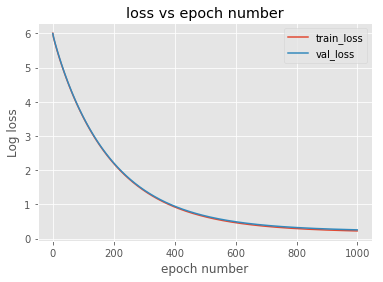

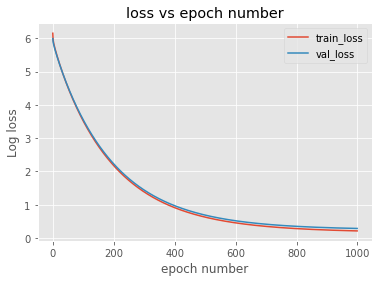

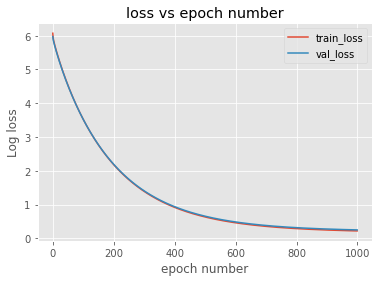

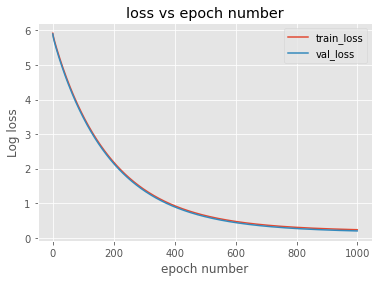

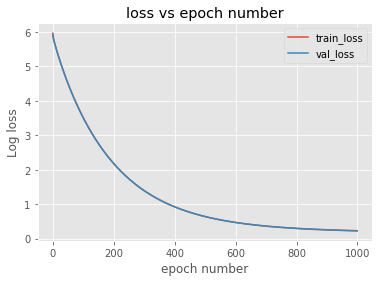

In [12]:
# Plot learning curves for validation and training data during learning
for history in train_results['history']:
    show_loss(history)

AttributeError: 'numpy.float64' object has no attribute 'history'

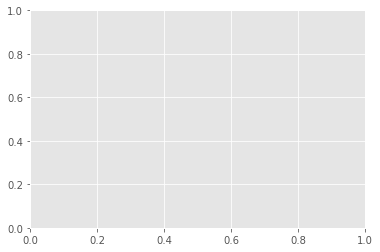

In [35]:
# Plot learning curves for validation and training data during learning
show_loss(np.average([history.history['val_loss'] for history in train_results['history']]))

In [37]:
for history in train_results['history']:
    print(type(history.history['val_loss']))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


# EVALUATION ON TEST DATASET

In [20]:
# Overall Accuracy, Precision, Recall and F1 score for test dataset for each model from cross validation

test_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}
confusion_matrixes = []
for model in train_results['models']:
    predicted = model.predict(x_test)
    
    predicted = np.asarray([np.round(j[0]) for j in predicted])
    actual = np.asarray([j[0] for j in y_test])
        
    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = metrics.accuracy_score(actual, predicted)
    
    test_results['Accuracy'].append(accuracy)
    test_results['Precision'].append(precision)
    test_results['Recall'].append(recall)
    test_results['F1_score'].append(f1)
    confusion_matrixes.append(confusion_matrix)
    
columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=test_results, columns=columns, index=indexes)
results_dataframe

,Accuracy,Precision,Recall,F1_score
K-fold 1,0.985148,0.098166,0.900990,0.177043
K-fold 2,0.984674,0.096234,0.910891,0.174078
K-fold 3,0.981338,0.079545,0.900990,0.146185
K-fold 4,0.980426,0.077500,0.920792,0.142967
K-fold 5,0.983656,0.089921,0.900990,0.163522


/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


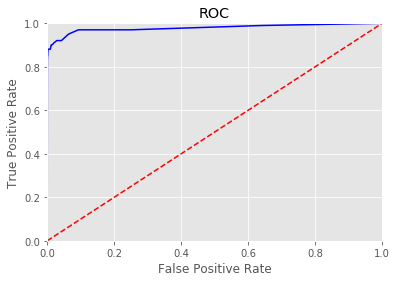

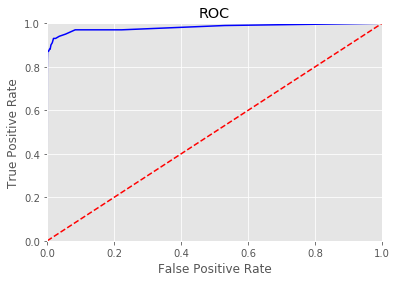

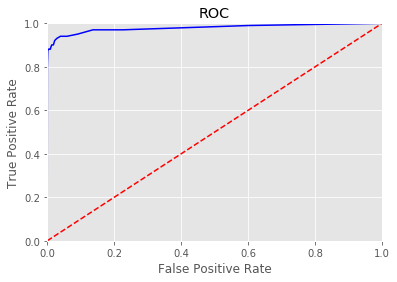

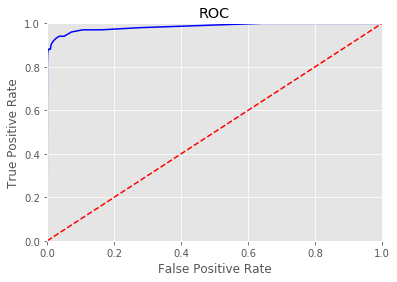

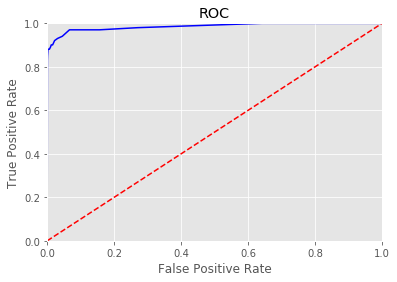

In [29]:
for model in train_results['models']:
    TPR_array = []
    FPR_array = []
    for i in range(-50,50,5):
        predicted = model.predict(x_test)
        predicted = np.asarray([np.round(j[0]+i/100) for j in predicted])
        actual = np.asarray([j[0] for j in y_test])

        TP = np.count_nonzero(np.multiply(predicted, actual))
        TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
        FP = np.count_nonzero(np.multiply(predicted, actual - 1))
        FN = np.count_nonzero(np.multiply(predicted - 1, actual))

        TPR_array.append(TP / (TP+FN))
        FPR_array.append(FP / (FP+TN))

    plot_ROC(TPR_array, FPR_array)

In [14]:
# Confusion matrixes for each valdation
for matrix in confusion_matrixes:
    display(matrix)


,actual 1,actual 0
predicted 1,91,836
predicted 0,10,56025


,actual 1,actual 0
predicted 1,92,864
predicted 0,9,55997


,actual 1,actual 0
predicted 1,91,1053
predicted 0,10,55808


,actual 1,actual 0
predicted 1,93,1107
predicted 0,8,55754


,actual 1,actual 0
predicted 1,91,921
predicted 0,10,55940
